# Machine Learning for Level Truncation in Bosonic Open String Field Theory

We consider the position of minima of the tachyon potential in bosonic open string field theory (OSFT) at mass level truncation of finite order. We then extrapolate predictions for level-$\infty$ truncation using machine learning (ML) techniques. In particular we will consider:

- [linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) (LR) to provide a solid baseline for the computation,
- [elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) (EN) to introduce $l_1$ and $l_2$ regularisation to weight the contributions (we could consider [lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) regression if we notice $l_1$ or $l_2$ are particularly favoured),
- [linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) (l-SVR) to introduce support vectors,
- [SVR (rbf kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) (SVR) to use the _kernel trick_ inside the support vectors,
- [random forests of decision trees](https://xgboost.readthedocs.io/en/latest/tutorials/rf.html) (RFs) to bag several decision trees and decrease the variance of the tree-based model,
- [boosted decision trees](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training) (BDTs) to increase the predictive ability to tackle the problem of reducing bias and variance (we also consider the case of boosted random forests of decision trees (BRF),
- [artificial neural networks](https://www.tensorflow.org) (ANNs) to introduce more complex regression functions.

In general we use [Scikit](https://scikit-learn.org) for most manipulations and [XGBoost](https://xgboost.ai/) for the BDTs. We then use [Tensorflow](https://www.tensorflow.org/) as a deep learning framework for the ANNs.

# Preanalysis

First of all we consider the dataset containing the positions of minimum points of the tachyon potential for several finite levels of mass truncation. Given a set of initial conditions, these are computed and stored in 'systems' (in the dataset there are 46 of them). Then the extrapolation for level-$\infty$ is given for each.

The idea is therefore to manipulate the system by studying the distribution of the systems: we flatten the database in order to have a feature matrix containing data for training and a vector of labels for the supervised learning. We also exclude duplicates (in this case, data identical over all columns) and identify the outliers of the distribution.

## Setup

The following analysis is performed on a machine with the following specifications:

In [1]:
!echo "CPU: $(lscpu| awk '/^Model name/ {$1=""; $2=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "GPU: $(lspci| awk '/3D controller/ {$1=""; $2=""; $3=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $2}')GB (avail. now: $(free --giga| awk '/^Mem/ {print $7}')GB)"

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 16GB (avail. now: 13GB)


Computations will be executed using a restricted amount of CPU threads:

In [2]:
multi_thread = 8

# sanitise the input
if multi_thread > 8:
    multi_thread = 8

We will use several module in this Python notebook. We import them early to take a look at their version number and to keep track of changes in the intallation:

In [3]:
import sys

import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import sklearn           as skl
import skopt             as skp
import tensorflow        as tf
import xgboost           as xgb

# Jupyter magics
%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.rc('axes', labelsize=12) #------- set size of the labels in Matplotlib
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# check for restrictions and print version number
try:
    assert np.__version__ >= '1.18.0', 'Numpy version should be at least 1.18.0 to avoid conflict with Pandas and PyTables'
    print('Numpy_version: {}'.format(np.__version__))
    
    assert pd.__version__ >= '1.0.0', 'Pandas version should be at least 1.0.0 to use PyTables correctly'
    print('Pandas version: {}'.format(pd.__version__))
    
    assert mpl.__version__ > '3.1.0', 'Matplotlib version should be at least 3.1.0'
    print('Matplotlib version: {}'.format(mpl.__version__))

    assert skl.__version__ >= '0.22.0', 'Scikit-learn version should be at least 0.22.0 to use newest implementations.'
    print('Scikit-learn version: {}'.format(skl.__version__))

    assert skp.__version__ >= '0.7.4', 'Scikit-optimize version should be at least 0.7.4 to use newest implementations.'
    print('Scikit-optimize version: {}'.format(skl.__version__))
    
    assert tf.__version__ >= '2.0.0', 'Tensorflow version should be at least 2.0.0 to use newest implementations.'
    print('Tensorflow version: {}'.format(tf.__version__))
    
    assert xgb.__version__ >= '0.88.0', 'XGBoost version should be at least 0.88.0 to use newest implementations.'
    print('XGBoost version: {}'.format(tf.__version__))
    
except AssertionError as msg:
    print(msg)
    
# fix the random seed
RAND = 42
np.random.seed(RAND)

Numpy_version: 1.18.4
Pandas version: 1.0.4
Matplotlib version: 3.2.1
Scikit-learn version: 0.23.1
Scikit-optimize version: 0.23.1
Tensorflow version: 2.0.0
XGBoost version: 2.0.0


We immediately set the memory growth for the gpu in order not to overflow it and avoid leaks when using Tensorflow:

In [4]:
# get gpus devices
gpus = tf.config.experimental.list_physical_devices('GPU')

# set memory growth
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Now create the directory structure and path names to work within the notebook:

In [5]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ images
MOD_DIR  = 'models' #--------------------------------------------- saved models
LOG_DIR  = 'log' #------------------------------------------------ logs
OUT_DIR  = 'output' #--------------------------------------------- saved predictions, relevant output, etc.

DB_NAME = 'data_sft_dict' #--------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.json' #------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

Finally create a logging session to store debug info:

In [6]:
import logging
from mltools.liblog import create_logfile

LOG_NAME = 'sft-trunc-ml'
path_to_log = path.join(LOG_PATH, LOG_NAME + '.log') #------------------------- path to the log
log = create_logfile(path_to_log, name=LOG_NAME, level=logging.DEBUG) #---------- create log file and session

log.info('\n\n'
         '--------------------------------------------\n'
         '  MACHINE LEARNING FOR LEVEL TRUNCATION IN\n'
         '  BOSONIC OPEN STRING FIELD THEORY\n\n'
         '--------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '--------------------------------------------\n'
         '  Abstract:\n\n'
         '  We consider the position of the lumps of\n'
         '  the tachyon potential in bosonic open\n'
         '  string field theory at a finite mass level\n'
         '  truncation. We then extrapolate the\n'
         '  predictions for level-$\infty$ using\n'
         '  machine learning techniques.\n\n'
        )

Rotating existing logs...


## Importing the Database

We import the database containing the positions of the lumps of the tachyon potential:

In [7]:
if path.isfile(DB_PATH):
    df = pd.read_json(DB_PATH)
    
    if not df.empty:
        log.debug('Successfully imported {}'.format(DB_PATH))
    else:
        sys.stderr.write('Database is empty!')
        log.error('Database is empty!')
else:
    sys.stderr.write('Cannot find database!')

We then start to analyse the _dtypes_ of the columns to understand what the dataset is made of:

In [8]:
df.dtypes

init      object
exp       object
weight    object
type      object
2         object
3         object
4         object
5         object
6         object
7         object
8         object
9         object
10        object
11        object
12        object
13        object
14        object
15        object
16        object
17        object
18        object
dtype: object

And then we take a look at the first few entries to understand the composition of the dataset:

In [9]:
df.head(3)

,init,exp,weight,type,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]",...,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]"
1,"[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....",...,"[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9..."
2,"[1.001, 0, 1.001, 1.001, 1.001, 1.001, 0, 0, 0...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.24950074900124802, 0.9980...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000976232275641, -3.8820163895943e-06, 0.90...","[1.000976049237533, -5.9682788728782085e-06, 0...","[1.000952815386108, -1.689178344782202e-05, 0....","[1.000952352120989, -1.5047680126166993e-05, 0...","[1.000929855311967, -2.5515953552563565e-05, 0...","[1.000929190755388, -2.3264350581688953e-05, 0...",...,"[1.0009075350494, -3.03802946004187e-05, 0.664...","[1.000888236249875, -3.860013055708573e-05, 0....","[1.000887354078869, -3.657126395737419e-05, 0....","[1.000869431716091, -4.387998808033297e-05, 0....","[1.000868490272024, -4.199905525467674e-05, 0....","[1.000851773655717, -4.853491335211209e-05, 0....","[1.000850791489764, -4.6788451470318466e-05, 0...","[1.000835137520457, -5.266383019452565e-05, 0....","[1.000834127701389, -5.1036790056833293e-05, 0...","[1.000819417460843, -5.634321216588246e-05, 0...."


In total we are dealing with a dataset of shape:

In [10]:
df.shape

(46, 21)

In the dataset we have therefore different predictions for the position of the lumps of the bosonic potential: they correspond to different choices of the initial point and other properties and data for 18 levels of mass truncation are provided together with the extrapolation for the level-$\infty$.

## Features Extraction and Manipulation

Before moving to the analysis we need to extract the modify the features in the dataset.

First of all we exclude the first entry which looks too static and artificially "perfect" to help in the predictions.

In [11]:
df = df[1:].reset_index(drop=True) #------ drop first entry and reset the index counter (do not include former index as column)
print('New shape of the dataset: {}'.format(df.shape))

log.info('Dropped first entry of the dataset. New shape: {}'.format(df.shape))

New shape of the dataset: (45, 21)


We then check that row-wise the size of the elements is unique:

In [12]:
df_sizes = df.applymap(np.shape)\
             .apply(np.unique, axis=1) #-------------------------------- compute the shape of each element of the dataframe and
#----------------------------------------------------------------------- take the unique values in each row

df_sizes_if_unique = df_sizes.apply(lambda x: np.shape(x) == (1,))\
                             .sum(axis=0) #----------------------------- check if each row contains only one element and
#----------------------------------------------------------------------- sum True values which should equal the size of the dataframe

try:
    assert df_sizes_if_unique == df.shape[0], 'Sizes along rows are not unique!'
    log.info('Sizes along rows are unique.')
except AssertionError as msg:
    log.error(msg)
    print(msg)

We then add one column which represents the position of each datum inside its own system of solutions:

In [13]:
def pad_index(index, shape):
    '''
    Pad the index number with a certain shape.
    
    Required arguments:
        index: the index to pad
        shape: the shape of the padding
        
    Returns:
        the padded index
    '''
    
    return [index] * np.prod(shape)

def pad_index_list(index_list, shape_list):
    '''
    Pad the entire list of indices.
    
    Required arguments:
        index_list: list of indices to pad
        shape_list: list of shapes of the paddings
    '''
    
    try:
        assert df.shape[0] == df_sizes.shape[0]
    except AssertionError as msg:
        print(msg)
        
    full_list = []
    for n in range(df.shape[0]):
        full_list.append(pad_index(index_list[n], shape_list[n]))
        
    return full_list

# add the column with the list of indices
df['system'] = pad_index_list(df.index, df_sizes.apply(lambda x: x[0]))
log.info('Add "system" feature as reference.')

# reorder the dataframe
df = df[['system', 'init', 'weight', 'type', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', 'exp']]

We then "flatten" the systems: for each system we build a new dataframe and then concatenate each of the new dataframes.

In [14]:
df_flat = pd.concat([pd.DataFrame({f: df[f].iloc[n] for f in df}) for n in range(df.shape[0])], axis=0, ignore_index=True)
log.debug('New flattened dataframe has been built.')

# describe the new dataset
df_flat.describe()

,system,init,weight,type,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,exp
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,...,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,7.630000e+02,763.000000
mean,23.237221,0.900145,1.864810,3.764089,-1.486604,-1.646112,7.572923,8.009875,-32.442704,-33.974851,...,-707.859825,-730.665421,2880.727031,2962.131627,-10880.473304,-11156.002595,38233.218285,39115.222069,-1.256117e+05,0.568807
std,13.025317,1.018137,2.314590,0.645534,4.459840,4.903356,20.975753,22.199837,108.036621,113.190933,...,2772.330578,2859.981462,11577.937424,11896.896973,44115.397542,45204.266729,155584.082650,159093.092977,5.129852e+05,0.694124
min,0.000000,0.000000,0.000000,2.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,...,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,12.000000,0.000000,0.040825,4.000000,-0.685810,-0.973798,0.000000,0.000000,-0.896869,-0.915398,...,-1.022243,-1.073550,0.001907,0.001975,-2.093628,-4.152302,0.139497,0.124570,-6.801183e+00,0.000000
50%,24.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.938337,0.944864,0.000000,0.002741,...,0.002597,0.002644,0.999960,0.997910,0.473076,0.550104,1.005628,1.005427,8.994815e-01,1.000000
75%,35.000000,1.750000,2.985594,4.000000,0.912406,0.992236,1.347502,1.486801,0.991624,1.000029,...,1.000028,1.004544,3.385307,5.228127,1.006120,1.006436,7.344206,10.777103,1.005195e+00,1.000000
max,44.000000,3.000000,9.000000,4.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,...,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


## Duplicates Search and Outliers Detection

We then analyse the new dataset in search of duplicates and outliers. We will drop the firsts, while we will keep the seconds even though we want to identify them.

In [15]:
df_nodup = df_flat.drop_duplicates(ignore_index=True)
df_nodup.describe()

,system,init,weight,type,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,exp
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,7.180000e+02,718.000000
mean,23.314763,0.836629,1.981686,3.749304,-1.649589,-1.817170,7.981259,8.445939,-34.541055,-36.169106,...,-752.288433,-776.523313,3061.210057,3147.716636,-11562.460857,-11855.258680,40629.386999,41566.669584,-1.334843e+05,0.541783
std,13.023788,1.004161,2.337013,0.662688,4.548304,5.005473,21.558408,22.815235,111.039170,116.338079,...,2852.135166,2942.302665,11912.541567,12240.685674,45391.801105,46512.063723,160087.941813,163698.216993,5.278422e+05,0.706857
min,0.000000,0.000000,0.000000,2.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,...,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,12.000000,0.000000,0.155340,4.000000,-0.819357,-1.048764,0.000000,0.000000,-0.924887,-0.941950,...,-1.122517,-2.123912,0.001518,0.001679,-3.214377,-6.185564,0.045728,0.042314,-2.569285e+01,0.000000
50%,24.000000,0.000000,1.000100,4.000000,0.000000,0.000000,0.923914,0.935052,0.000000,0.000000,...,0.001407,0.001712,0.987326,0.987066,0.001634,0.004821,1.004445,1.001084,9.732395e-02,1.000000
75%,35.000000,1.650000,3.213367,4.000000,0.795133,0.913984,1.408763,1.552803,0.960644,0.984305,...,0.991467,0.996329,4.397037,6.811820,0.997875,1.001248,16.098058,16.131990,1.003658e+00,1.000000
max,44.000000,3.000000,9.000000,4.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,...,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


We then look for outliers. However we have no idea how many of them are in the dataset, thus [`sklearn.EllipticEnvelope`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) is not a good choice. We use the _interquartile range_ (IQR) to detect outliers and decide (if needed) some boundaries for the outliers. We also define an _interdecile range_ (IDR) to select extreme outliers.

In [16]:
def iqr_detection(feature):
    '''
    Compute the interquartile range of a given feature and return the indices of the outliers.
    
    Required arguments:
        feature: the list of data to analyse.
        
    Returns:
        the list of indices of outliers.
    '''
    
    q1, q3 = np.percentile(feature, [25, 75]) #-------------------------------- get values of 1st and 3rd quartile
    iqr    = q3 - q1 #--------------------------------------------------------- compute the interquartile range (IQR)
    
    lower  = q1 - (iqr * 1.5) #------------------------------------------------ lower bound
    upper  = q3 + (iqr * 1.5) #------------------------------------------------ higher bound
    
    return np.where((feature > upper) | (feature < lower))[0].tolist() #------- return indices out of bounds

def idr_detection(feature):
    '''
    Compute the interdecile range and return indices of points outside the limit.
    
    Required arguments:
        feature: the list of data to analyse.
        
    Returns:
        the list of indices of outliers.
    '''
    
    d1, d9 = np.percentile(feature, [10, 90]) #-------------------------------- get values of 1st and 9th decile
    idr    = d9 - d1 #--------------------------------------------------------- compute the interdecile range (IDR)

    lower  = d1 - (idr * 1.5) #------------------------------------------------ lower bound
    upper  = d9 + (idr * 1.5) #------------------------------------------------ higher bound
    
    return np.where((feature > upper) | (feature < lower))[0].tolist() #------- return indice out of bounds

To give a few exemples:

In [17]:
for feature in df_nodup.columns:
    print('Number of outlying samples in "{}":         {:d}'.format(feature, np.shape(iqr_detection(df_nodup[feature]))[0]))
    print('Number of extreme outlying samples in "{}": {:d}'.format(feature, np.shape(idr_detection(df_nodup[feature]))[0]))
    print('\n')

Number of outlying samples in "system":         0
Number of extreme outlying samples in "system": 0


Number of outlying samples in "init":         0
Number of extreme outlying samples in "init": 0


Number of outlying samples in "weight":         45
Number of extreme outlying samples in "weight": 0


Number of outlying samples in "type":         90
Number of extreme outlying samples in "type": 0


Number of outlying samples in "2":         123
Number of extreme outlying samples in "2": 0


Number of outlying samples in "3":         122
Number of extreme outlying samples in "3": 3


Number of outlying samples in "4":         140
Number of extreme outlying samples in "4": 55


Number of outlying samples in "5":         138
Number of extreme outlying samples in "5": 54


Number of outlying samples in "6":         142
Number of extreme outlying samples in "6": 61


Number of outlying samples in "7":         142
Number of extreme outlying samples in "7": 61


Number of outlying samples in 

## Saving the Dataset

We finally save the dataset for further analysis.

In [18]:
df_nodup.to_json(path.join(ROOT_DIR, 'data_sft_analysis.json'))
df = df_nodup #------------------------------------------------- rename the variable for simpler referencing

log.debug('Dataset of the preanalysis saved to file.')

The number of elements for each system should be rather contained and can be visualised in a histogram:

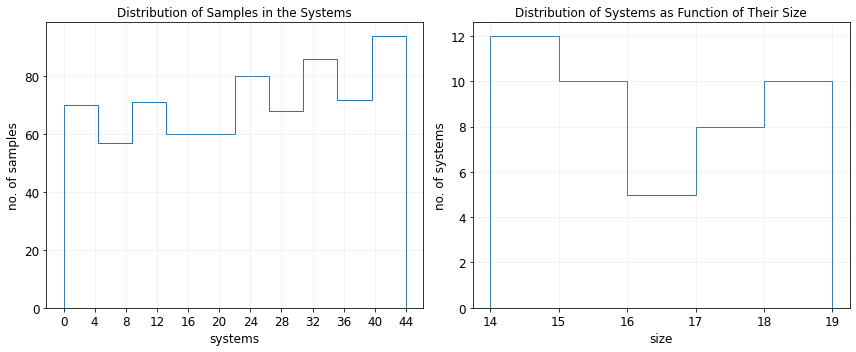

In [19]:
from mltools.libplot import Plot

hist_data = df.groupby(by=['system']).count().max(axis=1) #-------------- group by system, then count the number of elements and take a representative

plot = Plot(rows=1, columns=2)

plot.hist2D(df['system'],
            axis=0,
            title='Distribution of Samples in the Systems',
            xlabel='systems',
            ylabel='no. of samples',
            binstep=4
           )

plot.hist2D(hist_data,
            axis=1,
            title='Distribution of Systems as Function of Their Size',
            xlabel='size',
            ylabel='no. of systems',
            bins=range(hist_data.min(), hist_data.max() + 1, 1)
           )

plot.save_and_close(path.join(IMG_PATH, 'system_samples_distribution'))

# Analysis

We then move to the ML analysis using the previously described algorithms.

We first split the dataset into test and training set and then we select a portion of the training set to be used as development: this is done to preserve the ordering of the systems inside each set, in order to have samples coming from the same distributions. Cross validation (CV) would be a better choice, but the restricted number of samples in the training may spoil the results. Moreover data seems to have a good variability and any choice of the development set seem to reproduce it quite well.

We show the results of the predictions for each algorithm separately. Furthermore we first show the study operated through Bayes optimisation using [scikit-optimize](https://scikit-optimize.github.io) on the development set to avoid using the test set. We finally show the predictions for the test set.

## Test Set Selection

We split the training set into a test and training sets keeping samples of the same system in the same set. As our dataset is quite small, we will try to keep around 20% of data in the test set to keep a good predictive ability.

We first divide features from labels (in the features, we also drop the `init` column as we are not interested in using the initial values for the learning algorithms and the `system` column which will only be used to split training and test sets).

In [20]:
df = df.sample(frac=1, random_state=RAND) #-------------------------------------------------- first shuffle the dataset

log.debug('Starting the analysis. Database has been shuffled.')

We then split the dataset using the `system` label:

In [21]:
from sklearn.model_selection import train_test_split

train_system, test_system = train_test_split(df['system'].unique(), test_size=0.2, shuffle=False)

This leads to training and test set with the following shapes:

In [22]:
df_train = df.loc[df['system'].isin(train_system)]
df_test  = df.loc[df['system'].isin(test_system)]

# print the shape
print('Training set size: {:d} ({:.1f}% of the total dataset)'.format(df_train.shape[0], 100 * df_train.shape[0] / df.shape[0]))
print('Test set size:     {:d} ({:.1f}% of the total dataset)'.format(df_test.shape[0], 100 * df_test.shape[0] / df.shape[0]))

Training set size: 580 (80.8% of the total dataset)
Test set size:     138 (19.2% of the total dataset)


## Validation Strategy

For the same reason we used the `system` column to choose the training and test sets, we also need to use the same strategy for the validation set. Given the restricted size of the training dataset, we use a single _development set_ whose size must be decided. We use a linear regression to plot the error on the validation set as a function of the size of the development set. We clearly use the same approach as before: we take the `system` label, split the training set accordingly, fit the training data and evaluate on the development set.

In foresight of what we are going to do, we also apply a standardization to the training data.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_squared_error

# define what development set sizes to explore
dev_sizes = np.arange(0.15, 0.95, 0.05)

# save results in an array (made of [dev set size, mse] for each sample: shape = (dev_sizes.shape[0], 2))
results = np.zeros((dev_sizes.shape[0], 2))

# explore each dev size
for n in range(dev_sizes.shape[0]):
    
    # separate train and dev systems values
    train_system, dev_system = train_test_split(df_train['system'].unique(), test_size=dev_sizes[n], shuffle=False)

    # separate train and dev sets
    df_train_tmp = df_train.loc[df_train['system'].isin(train_system)].drop(columns=['system', 'init'])
    df_dev_tmp   = df_train.loc[df_train['system'].isin(dev_system)].drop(columns=['system', 'init'])

    # compute the size of the dev set w.r.t. the training set (it can differ from the size selected with the 'system' label)
    dev_set_size = df_dev_tmp.shape[0] / df_train.shape[0]

    # separate features from labels
    X_train, y_train = df_train_tmp.drop(columns='exp'), df_train_tmp['exp']
    X_dev,   y_dev   = df_dev_tmp.drop(columns='exp'),   df_dev_tmp['exp']

    # standardize the features
    std = StandardScaler()

    X_train = std.fit_transform(X_train)
    X_dev   = std.transform(X_dev)

    # compute the linear regression
    est = LinearRegression(fit_intercept=True, n_jobs=multi_thread)
    est.fit(X_train, y_train)

    # compute the predictions on the development set
    y_dev_pred = est.predict(X_dev)

    # compute the MSE on the predictions
    mse = mean_squared_error(y_dev, y_dev_pred)

    # save the results in the list
    results[n,:] = (dev_set_size, mse)

We then plot the results of the study:

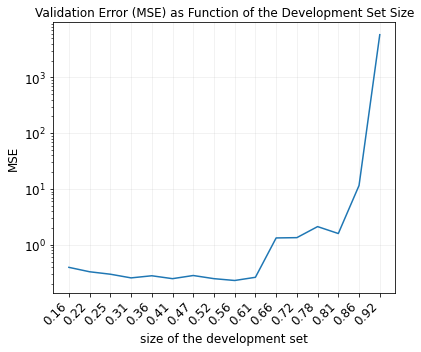

In [24]:
Plot().series2D(results[:,1],
                title='Validation Error (MSE) as Function of the Development Set Size',
                xlabel='size of the development set',
                ylabel='MSE',
                ylog=True,
                labels=np.around(results[:,0], decimals=2)
               ).save_and_close(path.join(IMG_PATH, 'val_strat_error'))

It seems that a good compromise between the number of samples and the validation error might be around 25% of the training set. We therefore select that value as a reference to split definitely the set:

In [25]:
# get the index of the 'results' vector which is closer the desired quantity and take the corresponding 'dev_sizes' position
chosen_dev_size = 0.25
[dev_size]      = dev_sizes[np.where(np.isclose(results[:,0], chosen_dev_size, atol=0.01))]

# split the datasets
train_system, dev_system = train_test_split(df_train['system'].unique(), test_size=dev_size, shuffle=False)
train_split = df_train.loc[df_train['system'].isin(train_system)].drop(columns=['system', 'init'])
dev_split   = df_train.loc[df_train['system'].isin(dev_system)].drop(columns=['system', 'init'])
test_split  = df_test.drop(columns=['system', 'init'])

# compute train, dev and test sizes
print('Training set size:    {:.1f}%'.format(100 * train_split.shape[0] / df.shape[0]))
print('Development set size: {:.1f}%'.format(100 * dev_split.shape[0] / df.shape[0]))
print('Test set size:        {:.1f}%'.format(100 * test_split.shape[0] / df.shape[0]))

log.info('Partition of train/dev/test: {:.1f}/{:.1f}/{:.1f}'.format(100 * train_split.shape[0] / df.shape[0],
                                                                    100 * dev_split.shape[0] / df.shape[0],
                                                                    100 * test_split.shape[0] / df.shape[0]
                                                                   )
        )

# divide features and labels
X_train, y_train = train_split.drop(columns='exp'), train_split['exp'].values.reshape(-1,1)
X_dev,   y_dev   = dev_split.drop(columns='exp'),   dev_split['exp'].values.reshape(-1,1)
X_test,  y_test  = test_split.drop(columns='exp'),  test_split['exp'].values.reshape(-1,1)

# apply the standardization
std     = StandardScaler()
X_train = std.fit_transform(X_train)
X_dev   = std.transform(X_dev)
X_test  = std.transform(X_test)

Training set size:    60.7%
Development set size: 20.1%
Test set size:        19.2%


## Machine Learning Analysis

We can now start to implement the regression algorithms we are trying to study. In general we use Bayes optimisation to tune the hyperparameters of the algorithm (exception made for linear regression: we will use a grid search) trying to minimise the mean squared error loss function.

For each algorithm we will try to output several metrics, even though we will only use the MSE to score the algorithm:

- _mean squared error_:
\begin{equation}
\mathrm{MSE}( y_{true}, y_{pred} ) = \frac{1}{N} \sum\limits_{i = 1}^N \left( y^{(i)}_{true} - y^{(i)}_{pred} \right) ^2,
\end{equation}

- _$R^2$ score_:
\begin{equation}
\mathrm{R}^2( y_{true}, y_{pred} ) = 1 - \frac{\sum\limits_{i = 1}^N \left( y^{(i)}_{true} - y^{(i)}_{pred} \right)^2}{\sum\limits_{i = 1}^N \left( y^{(i)}_{true} - \bar{y}_{pred} \right)^2}
\end{equation}
where
\begin{equation}
\bar{y}_{pred} = \frac{1}{N} \sum\limits_{i = 1}^N y^{(i)}_{true},
\end{equation}

- _explained variance score_:
\begin{equation}
\mathrm{EVar}( y_{true}, y_{pred} ) = 1 - \frac{\mathrm{Var}\{ y_{true} - y_{pred} \}}{\mathrm{Var}\{ y_{true} \}}.
\end{equation}

We will also compute the confidence interval of the variance: this represents the the range of values for which we have confidence that the variance estimated from the data is a good representative of the true error. We therefore fix here the confidence we are trying to achieve:

In [26]:
confidence = 0.95 #--- usually we set 95% of the variance (lower values are stricter)

### Linear Regression

We now consider a simple linear regression whose only hyperparameter is `fit_intercept` $\in \lbrace 0, 1 \rbrace$:

In [27]:
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, explained_variance_score, r2_score

# define the grid search
fit_intercept = np.array([False, True]).reshape(-1,1)

# define a vector of results with a shape (fit_intercept.shape[0], 3), where 3 is the number of metrics used
results = np.zeros((fit_intercept.shape[0], 3))

# define the estimator (set normalize to False since we already added standardization)
lin_reg = LinearRegression(normalize=False, n_jobs=multi_thread)
log.info('Fitting LR.')

# loop over the hyperparameter optimisation space and save the results in a dictionary
opt_results = {'fit_intercept': [],
               'mse':           [],
               'r2':            [],
               'evar':          []
              }
for n in range(fit_intercept.shape[0]):
    
    # insert hyperparameter in the estimator
    lin_reg.set_params(**{'fit_intercept': fit_intercept[n,:]})

    # fit the estimator
    lin_reg.fit(X_train, y_train)

    # generate predictions on the validation set
    y_dev_pred = lin_reg.predict(X_dev)

    # compute metrics
    mse  = mean_squared_error(y_dev, y_dev_pred) #---------- compute MSE
    r2   = r2_score(y_dev, y_dev_pred) #-------------------- compute R2
    evar = explained_variance_score(y_dev, y_dev_pred) #---- compute explained variance
    results[n,:] = (mse, r2, evar) #------------------------ add to the results
    
    # save to dictionary
    opt_results['fit_intercept'].append(fit_intercept[n,:].squeeze().tolist())
    opt_results['mse'].append(mse)
    opt_results['r2'].append(r2)
    opt_results['evar'].append(evar)
    
# look for the best results
best_arg     = np.argmin(results[:,0])
best_results = results[best_arg,:].reshape(-1,1)
best_params  = fit_intercept[best_arg,:].reshape(-1,1)

# retrain over the training set with the best parameters
lin_reg.set_params(**{'fit_intercept': fit_intercept[best_arg,:]})
lin_reg.fit(X_train, y_train)

# generate predictions on the dev set
y_dev_pred = lin_reg.predict(X_dev).reshape(-1,1)

# print the best results
print('Results for LR:\n\n'
      '  Best parameters:\n\n'
      '    fit_intercept: {}\n\n'
      '  MSE:  {:.3f}\n'
      '  R2:   {:.3f}\n'
      '  EVAR: {:.3f}'
      .format(best_params[0,:].squeeze(),
              best_results[0,:].squeeze(),
              best_results[1,:].squeeze(),
              best_results[2,:].squeeze()
             )
     )

# save results to file
joblib.dump(opt_results, path.join(OUT_PATH, 'lin_reg_dev_opt_res.pkl.xz'), compress=('xz', 9))

Results for LR:

  Best parameters:

    fit_intercept: True

  MSE:  0.297
  R2:   0.404
  EVAR: 0.408


['./output/lin_reg_dev_opt_res.pkl.xz']

The confidence interval can be estimated using a Student's $t$-distribution:

In [28]:
from scipy import stats

def confidence_interval(y_true, y_pred, confidence=0.95):
    '''
    Compute the confidence interval of the variance.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
        
    Returns:
        the array of lower and upper bounds of the confidence interval.
    '''
    
    # compute the deviation of the data and the squared errors
    deviation = y_pred - y_true #-------------------------------------- > 0 if overestimating, < 0 if underestimating
    sq_errors = deviation ** 2 #--------------------------------------- squared errors

    conf_interval = stats.t.interval(confidence,
                                     sq_errors.shape[0] - 1,
                                     loc=sq_errors.mean(),
                                     scale=stats.sem(sq_errors)
                                    ) #-------------------------------- compute the confidence interval
    
    return conf_interval

conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.095, 0.499 ]


We then save the model and its predictions for later use:

In [29]:
import joblib

def save_res(estimator, short_name):
    '''
    Save results to file.
    
    Required arguments:
        estimator:  the estimator to save,
        short_name: a short identifier of the estimator considered.
    '''
    # save the model to file
    joblib.dump(estimator, path.join(MOD_PATH, short_name + '.pkl.xz'), compress=('xz', 9))

    # save predictions to file
    dev_predictions = {'y_dev_true': y_dev.squeeze().tolist(),
                       'y_dev_pred': y_dev_pred.squeeze().tolist(),
                       'y_dev_err':  (y_dev_pred - y_dev).squeeze().tolist()
                      }
    joblib.dump(dev_predictions, path.join(OUT_PATH, short_name + '_dev_preds.pkl.xz'), compress=('xz', 9))

save_res(lin_reg, 'lin_reg')

We can also plot the absolute deviation of the predictions in various ways:

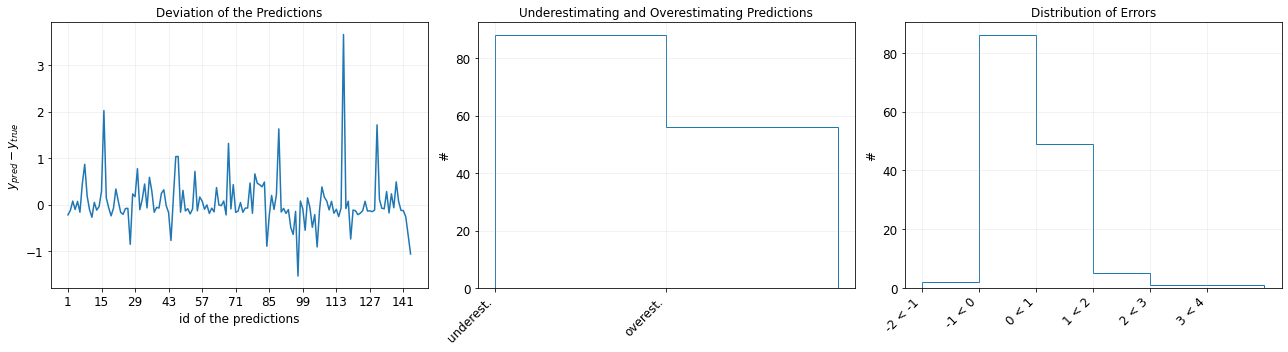

In [30]:
from sklearn.preprocessing import Binarizer

def error_visualisation(y_true, y_pred):
    '''
    Visualise plots of the variance of the errors.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
        
    Returns:
        the Matplotlib axis with the plots.
    '''
    # compute useful quantities
    deviation    = y_pred - y_true #----------------------------------------------- > 0 if overestimating, < 0 if underestimating
    binarization = Binarizer(threshold=0.0).transform(deviation) #----------------- +1 if overestimating, 0 if underestimating
    digit_bins   = range(int(np.ceil(deviation.min())),
                         int(np.ceil(deviation.max())) + 1
                        ) #-------------------------------------------------------- define the bins to discretize the deviation
    digitization = np.digitize(deviation, 
                               bins=digit_bins
                              ) #-------------------------------------------------- discretize deviation into unit bins

    # plot the results
    plot = Plot(rows=1, columns=3)

    plot.series2D(deviation,
                  axis=0,
                  title='Deviation of the Predictions',
                  xlabel='id of the predictions',
                  ylabel='$y_{pred} - y_{true}$',
                  binstep=14
                 )

    plot.hist2D(binarization,
                axis=1,
                title='Underestimating and Overestimating Predictions',
                ylabel='#',
                bins=[0,1,2],
                labels=['underest.', 'overest.']
               )

    plot.hist2D(digitization,
                axis=2,
                title='Distribution of Errors',
                ylabel='#',
                bins=range(len(digit_bins)+1),
                labels=['{} < {}'.format(n-1, n) for n in digit_bins]
               )
    
    return plot

plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'lin_reg_errors'))

Using LR we therefore see that:

- even though the MSE seems good, the variance has a very large confidence interval,
- in general linear regression seems to underestimate the true values,
- the distribution of the errors is peaked but in any case spread across a larger number of values,
- the $R^2$ and explained variance are similar but far from good.

### Elastic Net

We now consider the linear regression in the presence of $l_1$ and $l_2$ regularisation. We will need to study the hyperparameter space given by the choice of `fit_intercept` as in the linear regression, but also `alpha` and `l1-ratio` which control the regularisation: `alpha` $\times$ `l1_ratio` is the magnitude of the $l_1$ regularisation, while `alpha` $\times (1 -$ `l1_ratio` $) / 2$ controls the $l_2$ regularisation.

In [31]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics      import mean_squared_error, explained_variance_score, r2_score
from skopt                import gp_minimize
from skopt.space          import Real, Integer
from skopt.utils          import use_named_args

# define the hyperparameter search space
hyp_names  = ['fit_intercept', 'alpha', 'l1_ratio']
hyp_search = [Integer(0, 1, name=hyp_names[0]),
              Real(1.0e-9, 1.0e-6, prior='log-uniform', name=hyp_names[1]),
              Real(0.0, 1.0, name=hyp_names[2])
             ]

# define the number of iterations of the optimisation
n_calls    = 10

# define the estimator
el_net = ElasticNet(normalize=False, #------------------------ keep normalize = 0 since we already standardize the features
                    max_iter=1e8, #--------------------------- it seems that to have good convergence we need an insane amount of iterations:
                    tol=1.0e-2,   #   ^^^--------------------- do not go beyond n_calls = 10 or it takes forever!
                    random_state=RAND
                   )
log.info('Fitting EN.')

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    el_net.set_params(**params)
    el_net.fit(X_train, y_train)
    
    # compute predictions on the dev set
    y_dev_pred = el_net.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
el_net_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(el_net_res, path.join(OUT_PATH, 'el_net_dev_opt_res.pkl.xz'), compress=('xz', 9))

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.59739359558328, tolerance: 2.159885321100918
  positive)
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.682878650225007, tolerance: 2.159885321100918
  positive)
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.14421785304171, tolerance: 3.47
  positive)
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

We the print the results and compute the metrics:

In [32]:
# retrieve best results, fit to the training set and print
el_net.set_params(**dict(zip(hyp_names, el_net_res.x))) #----- set parameters to best possible choice
el_net.fit(X_train, y_train) #-------------------------------- fit again on the training set
y_dev_pred = el_net.predict(X_dev).reshape(-1,1) #------------ compute predictions

# print the metrics
def print_hyperparameters(names, results):
    '''
    Print best hyperparameters.
    
    Required arguments:
        names:   the names of the hyperparameters,
        results: results of the evaluation containing the hyperparameters.
    '''
    print('  Best hyperparameters:\n')
    for name, value in zip(names, results.x):
        print('    {}: {}'.format(name, value))
    
def print_metrics(y_true, y_pred):
    '''
    Print regression metrics.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
    '''
    print('\n  MSE:  {:.3f}'.format(mean_squared_error(y_true, y_pred)))
    print('  R2:   {:.3f}'.format(r2_score(y_true, y_pred)))
    print('  EVAR: {:.3f}'.format(explained_variance_score(y_true, y_pred)))
    
print('Results for EN:\n')
print_hyperparameters(hyp_names, el_net_res)  
print_metrics(y_dev, y_dev_pred)

Results for EN:

  Best hyperparameters:

    fit_intercept: 1
    alpha: 2.5135566617708297e-08
    l1_ratio: 0.8599404067363208

  MSE:  0.316
  R2:   0.367
  EVAR: 0.373


/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.71140972745218, tolerance: 2.159885321100918
  positive)


Results can then be completed by computing the confidence interval:

In [33]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.091, 0.540 ]


We then save the results to file:

In [34]:
save_res(el_net, 'el_net')

Finally we visualise the distribution of the variance of the errors in plots:

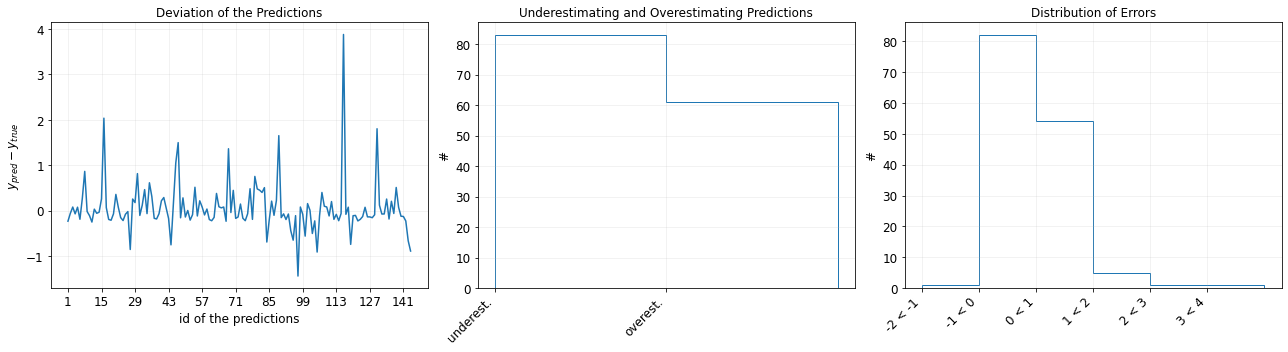

In [35]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'el_net_errors'))

With the introduction of regularisation we find:

- in general the MSE is worse, and the confidence interval seems to be larger,
- errors are in general underestimating, but they are confined in a smaller range,
- overestimating errors tend to have larger absolute deviations,
- $R^2$ and explained variance are again similar but worse than the simple linear regression,
- the algorithm seems to prefer a very small $l_1$ regularization (any an almost vanishing $l_2$ regularisation).

### Lasso

Given the results of the elastic net, we implement the lasso regression which a pure $l_1$ regularisation. We will therefore control only one hyperparameter `alpha` which represents the magnitude of the regularisation.

In [36]:
from sklearn.linear_model import Lasso
from sklearn.metrics      import mean_squared_error, explained_variance_score, r2_score
from skopt                import gp_minimize
from skopt.space          import Real, Integer
from skopt.utils          import use_named_args

# define the hyperparameter search space
hyp_names  = ['fit_intercept', 'alpha']
hyp_search = [Integer(0, 1, name=hyp_names[0]),
              Real(1.0e-9, 1.0e-4, prior='log-uniform', name=hyp_names[1])
             ]

# define the number of iterations of the optimisation
n_calls    = 10

# define the estimator
lasso = Lasso(normalize=False, #------------------------ keep normalize = 0 since we already standardize the features
              max_iter=1e8, #--------------------------- it seems that to have good convergence we need an insane amount of iterations:
              tol=1.0e-2,   #   ^^^--------------------- do not go beyond n_calls = 10 or it takes forever!
              random_state=RAND
             )
log.info('Fitting Lasso.')

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    lasso.set_params(**params)
    lasso.fit(X_train, y_train)
    
    # compute predictions on the dev set
    y_dev_pred = lasso.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
lasso_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(lasso_res, path.join(OUT_PATH, 'lasso_dev_opt_res.pkl.xz'), compress=('xz', 9))

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.13739032398151, tolerance: 2.159885321100918
  positive)
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.48628027210451, tolerance: 3.47
  positive)
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.58784922867744, tolerance: 3.47
  positive)
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to in

We the print the results and compute the metrics:

In [37]:
# retrieve best results, fit to the training set and print
lasso.set_params(**dict(zip(hyp_names, lasso_res.x))) #----- set parameters to best possible choice
lasso.fit(X_train, y_train) #-------------------------------- fit again on the training set
y_dev_pred = lasso.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for LASSO:\n')
print_hyperparameters(hyp_names, lasso_res)
print_metrics(y_dev, y_dev_pred)

Results for LASSO:

  Best hyperparameters:

    fit_intercept: 1
    alpha: 9.64385761594144e-07

  MSE:  0.317
  R2:   0.364
  EVAR: 0.370


Results can then be completed by computing the confidence interval:

In [38]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.090, 0.543 ]


We then save the results to file:

In [39]:
save_res(lasso, 'lasso')

Finally we visualise the distribution of the variance of the errors in plots:

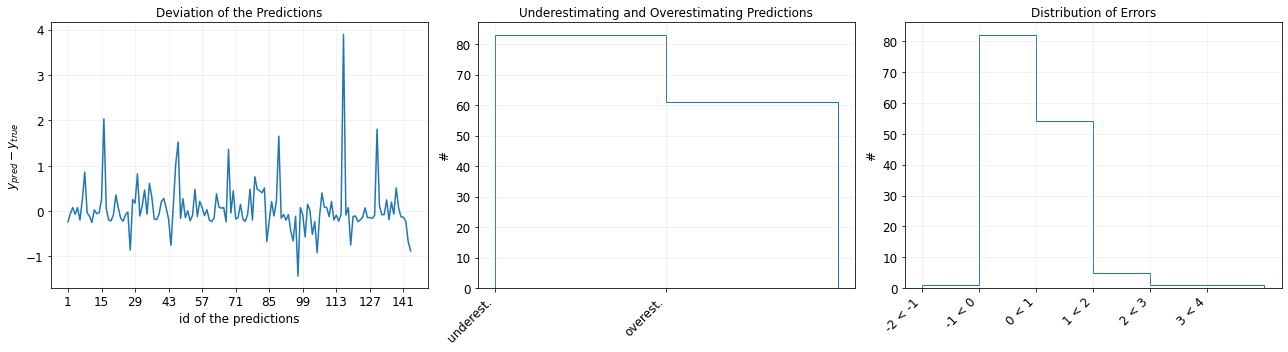

In [40]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'lasso_errors'))

Given the elastic net regression, we introduced just the $l_1$ regularised version of linear regression:

- we find the same scores as for the elastic net ($l_2$ regularisation does not influence the results),
- the confidence interval is the same as in the elastic net,
- underestimating errors are restricted to a small interval, while overestimating errors are in general spread across several values.

All in all, it seems that adding the regularisation is not helping.

### Linear SVR

We now study the support vector machine without using the kernel trick. We will therefore control a wider range of possible hyperparameters mainly related to the _soft margin_ implementation of SVR for regression.

In [41]:
from sklearn.svm     import LinearSVR
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# define the hyperparameter search space
hyp_names  = ['fit_intercept', #------------ intercept fitting (True/False)
              'epsilon', #------------------ penalty free boundary
              'C', #------------------------ penalty magnitude
              'loss', #--------------------- loss function (l1 or l2)
              'intercept_scaling' #--------- scale the intercept (if fitting)
             ]
hyp_search = [Integer(0, 1, name=hyp_names[0]),
              Real(1.0e-10, 1.0e-7, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-1, 1.0e3, prior='log-uniform', name=hyp_names[2]),
              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'], name=hyp_names[3]),
              Real(1.0e-3, 1.0e1, prior='log-uniform', name=hyp_names[4])
             ]

# define the number of iterations of the optimisation
n_calls    = 30

# define the estimator
lin_svr = LinearSVR(dual=True,
                    max_iter=1e7,
                    random_state=RAND
                   )
log.info('Fitting l-SVR.')

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    lin_svr.set_params(**params)
    lin_svr.fit(X_train, y_train.ravel())
    
    # compute predictions on the dev set
    y_dev_pred = lin_svr.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
lin_svr_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(lin_svr_res, path.join(OUT_PATH, 'lin_svr_dev_opt_res.pkl.xz'), compress=('xz', 9))

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We the print the results and compute the metrics:

In [42]:
# retrieve best results, fit to the training set and print
lin_svr.set_params(**dict(zip(hyp_names, lin_svr_res.x))) #---- set parameters to best possible choice
lin_svr.fit(X_train, y_train.ravel()) #------------------------ fit again on the training set
y_dev_pred = lin_svr.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for l-SVR:\n')
print_hyperparameters(hyp_names, lin_svr_res)
print_metrics(y_dev, y_dev_pred)

Results for l-SVR:

  Best hyperparameters:

    fit_intercept: 1
    epsilon: 4.570008761629886e-09
    C: 21.538725165335272
    loss: squared_epsilon_insensitive
    intercept_scaling: 0.0729139919834669

  MSE:  0.335
  R2:   0.327
  EVAR: 0.331


Results can then be completed by computing the confidence interval:

In [43]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.144, 0.527 ]


We then save the results to file:

In [44]:
save_res(lin_svr, 'lin_svr')

Finally we visualise the distribution of the variance of the errors in plots:

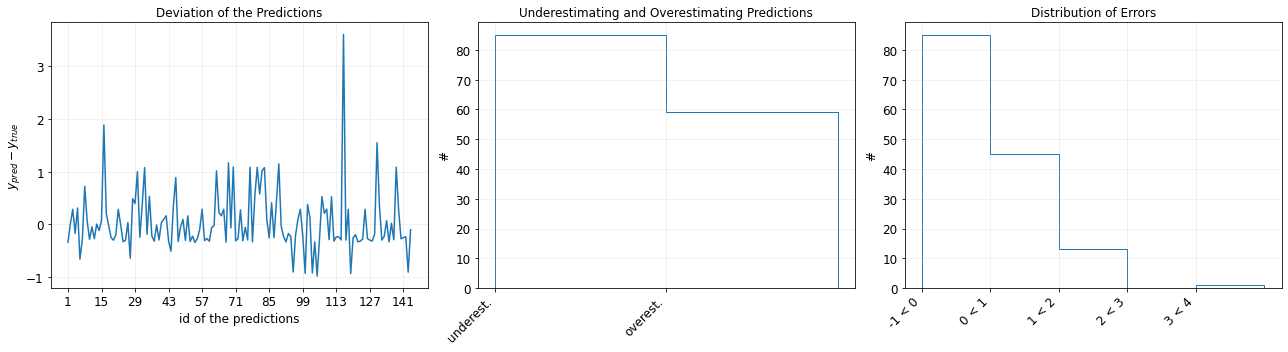

In [45]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'lin_svr_errors'))

It seems that the support vectors without the kernel trick do not improve the situation seen with the linear regression:

- we find the same scores as for the elastic net,
- the confidence interval is more restricted, signalling in any case a better convergence of the values,
- underestimating errors are restricted to a small interval, while overestimating errors are in general spread across several values.

### SVR (Gaussian kernel)

We then focus on SVR with the kernel trick: we consider a Gaussian kernel (_rbf_) and implement the analysis.

In [46]:
from sklearn.svm     import SVR
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# define the hyperparameter search space
hyp_names  = ['gamma', #------------------- variance^{-1} of the kernel distribution
              'epsilon', #----------------- penalty free boundary
              'C' #------------------------ magnitude of the penalty
             ]
hyp_search = [Real(1.0e-3, 1.0e-1, prior='log-uniform', name=hyp_names[0]),
              Real(1.0e-4, 1.0e1, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-2, 1.0e3, prior='log-uniform', name=hyp_names[2])
             ]

# define the number of iterations of the optimisation
n_calls    = 40

# define the estimator
svr_rbf = SVR(kernel='rbf')
log.info('Fitting SVR.')

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    svr_rbf.set_params(**params)
    svr_rbf.fit(X_train, y_train.ravel())
    
    # compute predictions on the dev set
    y_dev_pred = svr_rbf.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
svr_rbf_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(svr_rbf_res, path.join(OUT_PATH, 'svr_rbf_dev_opt_res.pkl.xz'), compress=('xz', 9))

We the print the results and compute the metrics:

In [47]:
# retrieve best results, fit to the training set and print
svr_rbf.set_params(**dict(zip(hyp_names, svr_rbf_res.x))) #---- set parameters to best possible choice
svr_rbf.fit(X_train, y_train.ravel()) #------------------------ fit again on the training set
y_dev_pred = svr_rbf.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for SVR (rbf kernel):\n')
print_hyperparameters(hyp_names, svr_rbf_res)
print_metrics(y_dev, y_dev_pred)

Results for SVR (rbf kernel):

  Best hyperparameters:

    gamma: 0.05400755042055806
    epsilon: 0.017959676064756954
    C: 1000.0

  MSE:  0.084
  R2:   0.831
  EVAR: 0.833


Results can then be completed by computing the confidence interval:

In [48]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.012, 0.156 ]


We then save the results to file:

In [49]:
save_res(svr_rbf, 'svr_rbf')

Finally we visualise the distribution of the variance of the errors in plots:

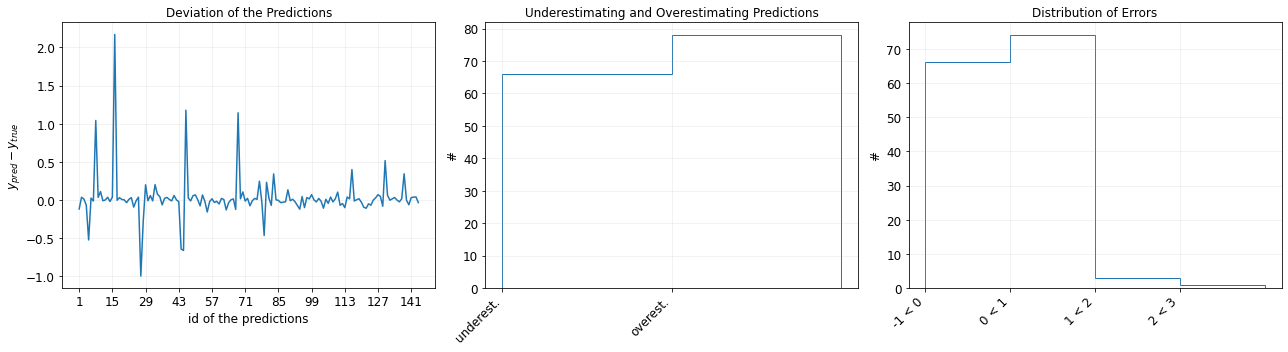

In [50]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'svr_rbf_errors'))

The introduction of the kernel trick seems to drastically improve the situation:

- the value of the MSE is significantly reduces and the $R^2$ and explained variance show a better results,
- the confidence interval peaked around the value of the MSE,
- underestimating and overestimating errors seem to be balanced and restricted to smaller intervals.

### Random Forests

We then consider the predictions given by a standalone forest of fully grown decision trees. In this case the number of tunable hyperparameters is quite high, but we can expect a shorter training time given the restricted amount of training samples.

In [51]:
import xgboost       as xgb
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# convert training data to DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)
ddev   = xgb.DMatrix(X_dev,   label=y_dev)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# define the hyperparameter search space
hyp_names  = ['max_depth', #----------------- max. depth of a tree [1, inf)
              'min_child_weight', #---------- min. sum of instance weight (Hessian) needed in a child [0, inf)
              'gamma', #--------------------- min. loss reduction required to make a further partition on a leaf node of the tree [0, inf)
              'subsample', #----------------- subsample ratio of the training instances (0,1]
              'colsample_bytree', #---------- subsample ratio of columns when constructing each tree (0,1]
              'lambda', #-------------------- l2 regularisation
              'alpha', #--------------------- l1 regularisation
              'num_parallel_tree' #---------- number of trees in the forest
             ]
hyp_search = [Integer(25, 150, name=hyp_names[0]),
              Real(1.0e-2, 1.0e-1, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-2, 1.0e2, prior='log-uniform', name=hyp_names[2]),
              Real(0.01, 1.0, name=hyp_names[3]),
              Real(0.01, 1.0, name=hyp_names[4]),
              Real(1.0e-6, 1.0e-1, prior='log-uniform', name=hyp_names[5]),
              Real(1.0e-6, 1.0e-1, prior='log-uniform', name=hyp_names[6]),
              Integer(2, 200, name=hyp_names[7])
             ]
log.info('Fitting RF.')

# define the number of iterations of the optimisation
n_calls    = 40

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # add more parameters
    params['learning_rate'] = 1
    params['objective']     = 'reg:squarederror'
    params['tree_method']   = 'hist'
    params['seed']          = RAND
    
    # fit the estimator
    rnd_for = xgb.train(params, dtrain, num_boost_round=1, evals=[(ddev, 'eval'), (dtrain, 'train')], verbose_eval=False)
    
    # compute predictions on the dev set and release the memory
    y_dev_pred = rnd_for.predict(ddev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
rnd_for_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(rnd_for_res, path.join(OUT_PATH, 'rnd_for_dev_opt_res.pkl.xz'), compress=('xz', 9))

We the print the results and compute the metrics:

In [52]:
# retrieve best results, fit to the training set and print
params = dict(zip(hyp_names, rnd_for_res.x)) #--------------------------- set parameters to best possible choice
rnd_for = xgb.train(params,
                    dtrain,
                    num_boost_round=1,
                    evals=[(ddev, 'eval'), (dtrain, 'train')],
                    verbose_eval=False) #-------------------------------- fit again on the training set
y_dev_pred = rnd_for.predict(ddev).reshape(-1,1) #----------------------- compute predictions

print('Results for the random forest:\n')
print_hyperparameters(hyp_names, rnd_for_res)
print_metrics(y_dev, y_dev_pred)

Results for the random forest:

  Best hyperparameters:

    max_depth: 53
    min_child_weight: 0.015136238047451603
    gamma: 0.14011394364742835
    subsample: 0.14182298911460872
    colsample_bytree: 0.6884207642729826
    lambda: 0.08709404632115259
    alpha: 1.631933465725435e-05
    num_parallel_tree: 200

  MSE:  0.286
  R2:   0.426
  EVAR: 0.427


Results can then be completed by computing the confidence interval:

In [53]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.219, 0.353 ]


We then save the results to file:

In [54]:
save_res(rnd_for, 'rnd_for')

Finally we visualise the distribution of the variance of the errors in plots:

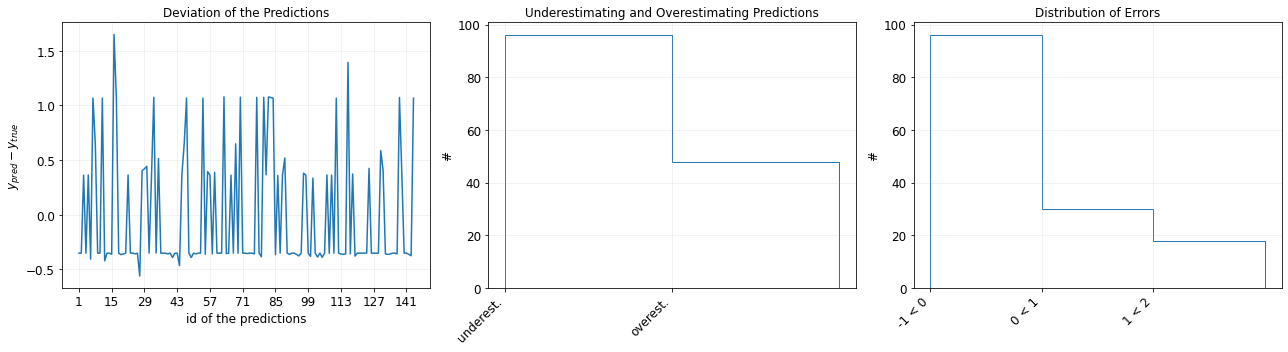

In [55]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'rnd_for_errors'))

Decision trees seem to slighlty improve the confidence of the results but do not significantly improve the situation:

- the values of the MSE and the other scores are comparable with linear regression (w/o regularisation),
- the confidence interval is definitely more peaked,
- errors seem to be mainly underestimating the true values and are contained in small intervals.

### Boosted Trees

We then implement the gradient boosting of shallow trees to improve previous results. In this case we add boosting rounds while we keep only one tree per round:

In [56]:
import xgboost       as xgb
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# convert training data to DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)
ddev   = xgb.DMatrix(X_dev,   label=y_dev)

# define the hyperparameter search space
hyp_names  = ['max_depth', #----------------- max. depth of a tree [1, inf)
              'min_child_weight', #---------- min. sum of instance weight (Hessian) needed in a child [0, inf)
              'gamma', #--------------------- min. loss reduction required to make a further partition on a leaf node of the tree [0, inf)
              'subsample', #----------------- subsample ratio of the training instances (0,1]
              'colsample_bytree', #---------- subsample ratio of columns when constructing each tree (0,1]
              'lambda', #-------------------- l2 regularisation
              'alpha', #--------------------- l1 regularisation
              'learning_rate', #------------- learning rate of gradient descent
              'num_boost_round' #------------ number of boosting rounds
             ]
hyp_search = [Integer(1, 50, name=hyp_names[0]),
              Real(1.0e-2, 1.0e-1, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-2, 1.0e2, prior='log-uniform', name=hyp_names[2]),
              Real(0.01, 1.0, name=hyp_names[3]),
              Real(0.01, 1.0, name=hyp_names[4]),
              Real(1.0e-6, 1.0e-1, prior='log-uniform', name=hyp_names[5]),
              Real(1.0e-8, 1.0e-4, prior='log-uniform', name=hyp_names[6]),
              Real(1.0e-5, 1.0e-1, prior='log-uniform', name=hyp_names[7]),
              Integer(500, 1500, name=hyp_names[8])
             ]
log.info('Fitting BDT.')

# define the number of iterations of the optimisation
n_calls    = 30

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    # save the number of boosting rounds
    num_boost_round = params['num_boost_round']
    
    # create new dictionary without num_boost_round
    params = {key: value for key, value in params.items() if key != 'num_boost_round'}
    params['seed'] = RAND
    
    # add more parameters
    params['num_parallel_tree'] = 1
    params['objective']         = 'reg:squarederror'
    params['tree_method']       = 'hist'
    params['seed']              = RAND
    
    # fit the estimator
    bst_tree = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(ddev, 'eval'), (dtrain, 'train')], verbose_eval=False)
    
    # compute predictions on the dev set and release the memory
    y_dev_pred = bst_tree.predict(ddev).reshape(-1,1)
    del bst_tree
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
bst_tree_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(bst_tree_res, path.join(OUT_PATH, 'bst_tree_dev_opt_res.pkl.xz'), compress=('xz', 9))

We the print the results and compute the metrics:

In [57]:
# retrieve best results, fit to the training set and print
params = dict(zip(hyp_names, bst_tree_res.x)) #------------------------------------------ set parameters to best possible choice
num_boost_round = params['num_boost_round'] #-------------------------------------------- save the value of the boosting rounds
params = {key: value for key, value in params.items() if key != 'num_boost_round'} #----- create new dictionary w/o boosting rounds
bst_tree = xgb.train(params,
                     dtrain,
                     num_boost_round=num_boost_round,
                     evals=[(ddev, 'eval'), (dtrain, 'train')],
                     verbose_eval=False) #----------------------------------------------- fit again on the training set
y_dev_pred = bst_tree.predict(ddev).reshape(-1,1) #-------------------------------------- compute predictions

print('Results for the boosted trees:\n')
print_hyperparameters(hyp_names, bst_tree_res)
print_metrics(y_dev, y_dev_pred)

Results for the boosted trees:

  Best hyperparameters:

    max_depth: 30
    min_child_weight: 0.018556995049460682
    gamma: 0.20170011066616403
    subsample: 0.3615626876778138
    colsample_bytree: 1.0
    lambda: 0.03557533530405934
    alpha: 4.530477706267553e-07
    learning_rate: 0.0026803277201098734
    num_boost_round: 1210

  MSE:  0.063
  R2:   0.874
  EVAR: 0.876


Results can then be completed by computing the confidence interval:

In [58]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.004, 0.121 ]


We then save the results to file:

In [59]:
save_res(bst_tree, 'bst_tree')

Finally we visualise the distribution of the variance of the errors in plots:

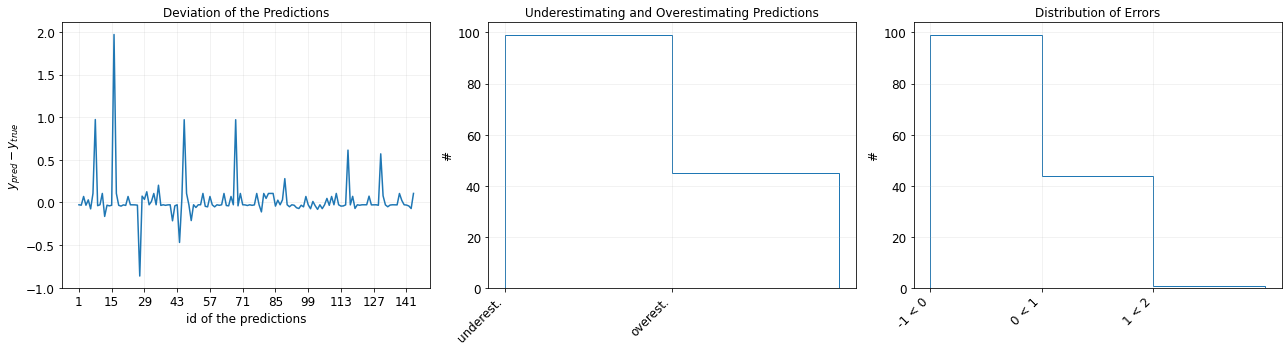

In [60]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'bst_tree_errors'))

Gradient boosting shows a vast improvement on the previous decision tree implementation:

- the values of the MSE and the other scores are even lower than SVR,
- the confidence interval is definitely peaked,
- errors seem to be mainly underestimating the true values and are contained in small intervals.

### Boosted Forests

As a curiosity we also implement boosted forests of decision trees to see whether this improves anything:

In [61]:
import xgboost       as xgb
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# convert training data to DMatrix for training
dtrain = xgb.DMatrix(X_train, label=y_train)
ddev   = xgb.DMatrix(X_dev,   label=y_dev)

# define the hyperparameter search space
hyp_names  = ['max_depth', #----------------- max. depth of a tree [1, inf)
              'min_child_weight', #---------- min. sum of instance weight (Hessian) needed in a child [0, inf)
              'gamma', #--------------------- min. loss reduction required to make a further partition on a leaf node of the tree [0, inf)
              'subsample', #----------------- subsample ratio of the training instances (0,1]
              'colsample_bytree', #---------- subsample ratio of columns when constructing each tree (0,1]
              'lambda', #-------------------- l2 regularisation
              'alpha', #--------------------- l1 regularisation
              'num_parallel_tree', #--------- number of trees in the forest
              'learning_rate', #------------- learning rate of gradient descent
              'num_boost_round' #------------ number of boosting rounds
             ]
hyp_search = [Integer(1, 15, name=hyp_names[0]),
              Real(1.0e-2, 1.0e-1, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-2, 1.0e2, prior='log-uniform', name=hyp_names[2]),
              Real(0.01, 1.0, name=hyp_names[3]),
              Real(0.01, 1.0, name=hyp_names[4]),
              Real(1.0e-6, 1.0e-1, prior='log-uniform', name=hyp_names[5]),
              Real(1.0e-6, 1.0e-1, prior='log-uniform', name=hyp_names[6]),
              Integer(2, 10, name=hyp_names[7]),
              Real(1.0e-5, 1.0e-1, prior='log-uniform', name=hyp_names[8]),
              Integer(500, 1500, name=hyp_names[9])
             ]
log.info('Fitting BRF.')

# define the number of iterations of the optimisation
n_calls    = 20

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    # save the number of boosting rounds
    num_boost_round = params['num_boost_round']
    
    # create new dictionary without num_boost_round
    params = {key: value for key, value in params.items() if key != 'num_boost_round'}
    
    # add more parameters
    params['objective']   = 'reg:squarederror'
    params['tree_method'] = 'hist'
    params['seed']        = RAND
    
    # fit the estimator
    bst_for = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(ddev, 'eval'), (dtrain, 'train')], verbose_eval=False)
    
    # compute predictions on the dev set and release the memory
    y_dev_pred = bst_for.predict(ddev).reshape(-1,1)
    del bst_for
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
bst_for_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(bst_for_res, path.join(OUT_PATH, 'bst_for_dev_opt_res.pkl.xz'), compress=('xz', 9))

We the print the results and compute the metrics:

In [62]:
# retrieve best results, fit to the training set and print
params = dict(zip(hyp_names, bst_for_res.x)) #------------------------------------------- set parameters to best possible choice
num_boost_round = params['num_boost_round'] #-------------------------------------------- save the value of the boosting rounds
params = {key: value for key, value in params.items() if key != 'num_boost_round'} #----- create new dictionary w/o boosting rounds
bst_for = xgb.train(params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(ddev, 'eval'), (dtrain, 'train')],
                    verbose_eval=False) #------------------------------------------------ fit again on the training set
y_dev_pred = bst_for.predict(ddev).reshape(-1,1) #--------------------------------------- compute predictions

print('Results for the boosted forest of trees:\n')
print_hyperparameters(hyp_names, bst_for_res)
print_metrics(y_dev, y_dev_pred)

Results for the boosted forest of trees:

  Best hyperparameters:

    max_depth: 7
    min_child_weight: 0.01965568459942485
    gamma: 0.01138463970530464
    subsample: 0.20685398004791716
    colsample_bytree: 0.7142285332211636
    lambda: 0.008930539642879314
    alpha: 0.0010710256549997944
    num_parallel_tree: 9
    learning_rate: 0.00402075954874985
    num_boost_round: 1415

  MSE:  0.063
  R2:   0.873
  EVAR: 0.875


Results can then be completed by computing the confidence interval:

In [63]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.003, 0.124 ]


We then save the results to file:

In [64]:
save_res(bst_for, 'bst_for')

Finally we visualise the distribution of the variance of the errors in plots:

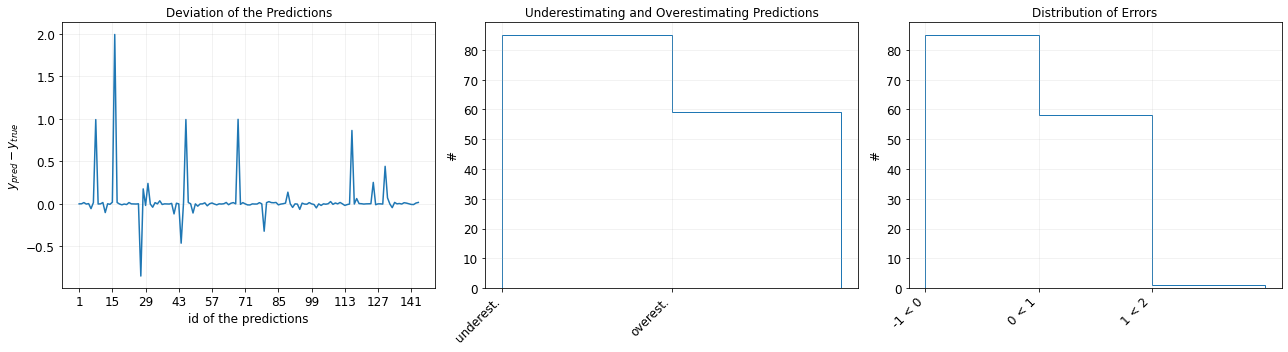

In [65]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'bst_for_errors'))

Boosted forests of trees seem do not seem to improve already achieved results:

- MSE and other scores are among the best results so far,
- the confidence interval is definitely peaked,
- errors seem to be mainly underestimating the true values but the number of large errors is reduced,
- the number of hyperparameters optimization necessary to obtain a good result is much smaller than BDT,
- in general boosted trees are more than enough to get the good predictions.

### Neural Networks

We finally implement an analysis based on ANNs. Given the small amount of sample data we try to keep the architecture as simple as possible. Given the distribution of the data we consider a fully connected (FC) ANN built using [Tensorflow](https://www.tensorflow.org/) and [Keras](https://www.tensorflow.org/guide/keras), its high level API.

In [83]:
from tensorflow.keras              import Sequential, metrics, losses
from tensorflow.keras.layers       import InputLayer, Dense, Activation, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers   import Adam

# define the input shape
input_shape = X_train.shape[1:]

# define the batch size for training
batch_size = X_train.shape[0]

# build the model
def ann_model(n_layers=1,
              n_units=10,
              learning_rate=0.1,
              epochs=10,
              activation='relu',
              slope=0.3,
              dropout=True,
              dropout_rate=0.2,
              batch_normalization=True,
              momentum=0.99,
              callbacks=None,
              verbose=0
             ):
    '''
    Create and return a compiled Tensorflow model.
    
    Required parameters:
    
    Optional parameters:
        n_layers:            the number of fully connected layers to insert,
        n_units:             the number of units in each layer,
        learning_rate:       the learning rate of gradient descent,
        epochs:              the number of epochs for training,
        activation:          the name of the activation function ('relu' for ReLU or else for LeakyReLU)
        slope:               the slope of the LeakyReLU activation (ignored if ReLU),
        dropout:             whether to use dropout,
        dropout_rate:        the dropout rate (ignored if no dropout),
        batch_normalization: whether to use batch normalization,
        momentum:            the momentum of batch normalization,
        callbacks:           the list of callbacks,
        verbose:             verbosity level.
    
    Returns:
        the fitted model and its history.
    '''

    # instantiate the model
    tf.keras.backend.clear_session()
    model = Sequential(name='sft_trunc') #----------------------------------------------- create the model
    model.add(InputLayer(input_shape=input_shape, name='input')) #----------------------- add the input layer of shape X_train.shape[1:]
    
    # add FC layers
    for n in range(n_layers):
        model.add(Dense(units=n_units,
                        kernel_initializer=glorot_uniform(seed=RAND),
                        bias_initializer=tf.zeros_initializer(),
                        name='dense_{:d}'.format(n)
                       )
                 ) #--------------------------------------------------------------------- add FC layer
        if activation == 'relu':
            model.add(Activation('relu',
                                 name='activation_{:d}'.format(n)
                                )
                     )
        else:
            model.add(LeakyReLU(alpha=slope,
                                name='activation_{:d}'.format(n)
                               )
                     ) #----------------------------------------------------------------- add activation layer
        if batch_normalization:
            model.add(BatchNormalization(momentum=momentum,
                                         name='batch_norm_{:d}'.format(n)
                                        )
                     ) #----------------------------------------------------------------- add batch normalization layer
        if dropout:
            model.add(Dropout(rate=dropout_rate,
                              seed=RAND,
                              name='dropout_{:d}'.format(n)
                             )
                     ) #----------------------------------------------------------------- add dropout layer
        
    # add the output layer
    model.add(Dense(units=1,
                    kernel_initializer=glorot_uniform(seed=RAND),
                    bias_initializer=tf.zeros_initializer(),
                    name='output'
                   )
             ) #------------------------------------------------------------------------- add output layer
    
    # compile the model
    model.compile(optimizers=Adam(learning_rate=learning_rate),
                  loss=losses.MeanSquaredError(),
                  metrics=[metrics.MeanSquaredError(),
                           metrics.RootMeanSquaredError(),
                           metrics.MeanAbsoluteError()
                          ]
                 )
    
    # fit the model
    model_history = model.fit(x=X_train,
                              y=y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=verbose,
                              validation_data=(X_dev, y_dev),
                              callbacks=callbacks
                             )
    
    # return the compiled model
    return model, model_history.history

We then define the objective function on which to perform the optimisation of the hyperparameters:

In [84]:
from skopt       import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args

# define the hyperparameter search space
hyp_names  = ['n_layers', #----------------- the number of fully connected layers to insert,
              'n_units', #------------------ the number of units in each layer,
              'learning_rate', #------------ the learning rate of gradient descent,
              'activation', #--------------- the name of the activation function ('relu' for ReLU or else for LeakyReLU)
              'slope', #-------------------- the slope of the LeakyReLU activation (ignored if ReLU),
              'dropout', #------------------ whether to use dropout,
              'dropout_rate', #------------- the dropout rate (ignored if no dropout),
              'batch_normalization', #------ whether to use batch normalization,
              'momentum', #----------------- the momentum of batch normalization
             ]
hyp_search = [Integer(1, 100, name=hyp_names[0]),
              Integer(1, 20, name=hyp_names[1]),
              Real(1.0e-4, 1.0e-2, prior='log-uniform', name=hyp_names[2]),
              Categorical(['relu', 'leaky'], name=hyp_names[3]),
              Real(1.0e-3, 1.0e-1, prior='log-uniform', name=hyp_names[4]),
              Integer(0, 1, name=hyp_names[5]),
              Real(1.0e-3, 5.0e-1, prior='uniform', name=hyp_names[6]),
              Integer(0, 1, name=hyp_names[7]),
              Real(0.1, 0.999, name=hyp_names[8])
             ]
log.info('Fitting ANN.')

# define the number of iterations of the optimisation
n_calls    = 20

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the loss function value of the dev set.
    '''
    # create the model
    _, history = ann_model(epochs=3000, **params)
    
    # return the minimum value of the loss achieved by the model during training
    return np.min(history['val_loss'])

# save the results of the optimisation
ann_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=1)
skp.dump(ann_res, path.join(OUT_PATH, 'ann_fc_dev_opt_res.pkl.xz'), compress=('xz', 9))

We the print the results and compute the metrics:

In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models    import load_model

# define a set of callbacks to save the best model
callbacks = [ModelCheckpoint(filepath=path.join(MOD_PATH, 'ann_fc.h5'),
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True
                            )
            ]

# retrieve best results, fit to the training set and print
params = dict(zip(hyp_names, ann_res.x)) #---------------------------------------------- set parameters to best possible choice
ann_fc, ann_fc_history = ann_model(callbacks=callbacks, epochs=3000, verbose=0, **params)

# reload last best model
if path.isfile(path.join(MOD_PATH, 'ann_fc.h5')):
    ann_fc = load_model(path.join(MOD_PATH, 'ann_fc.h5'))
else:
    log.error('Cannot load best ANN model!')

# compute the predictions
y_dev_pred = ann_fc.predict(X_dev).reshape(-1,1) #----------------------------------------- compute predictions

# save predictions to file
dev_predictions = {'y_dev_true': y_dev.squeeze().tolist(),
                   'y_dev_pred': y_dev_pred.squeeze().tolist(),
                   'y_dev_err':  (y_dev_pred - y_dev).squeeze().tolist()
                  }
joblib.dump(dev_predictions, path.join(OUT_PATH, 'ann_fc_dev_preds.pkl.xz'), compress=('xz', 9))

# print the results
print('Results for the ANN:\n')
print_hyperparameters(hyp_names, ann_res)
print_metrics(y_dev, y_dev_pred)

Results for the ANN:

  Best hyperparameters:

    n_layers: 5
    n_units: 15
    learning_rate: 0.15873754791183425
    activation: leaky
    slope: 0.005376831391500258
    dropout: 1
    dropout_rate: 0.029184071941804304
    batch_normalization: 1
    momentum: 0.9246642854493878

  MSE:  0.113
  R2:   0.772
  EVAR: 0.777


Results can then be completed by computing the confidence interval:

In [86]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.011, 0.215 ]


In the case of neural networks, it may be a good idea to plot and study the loss and metrics functions during training and validation:

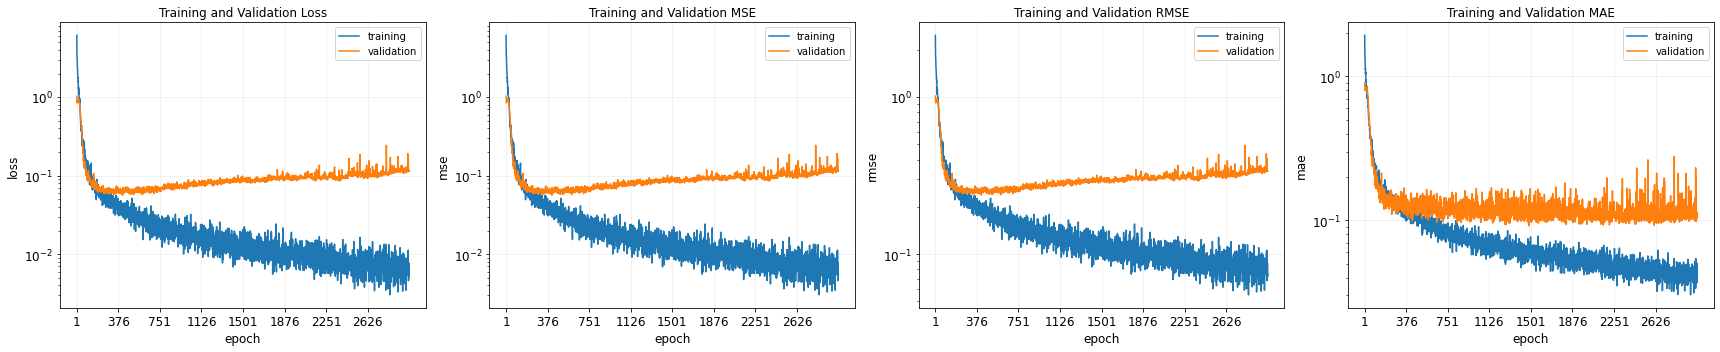

In [87]:
from mltools.libplot import Plot

plot = Plot(rows=1, columns=4)

plot.series2D(data=ann_fc_history['loss'],
              axis=0,
              title='Training and Validation Loss',
              xlabel='epoch',
              ylabel='loss',
              legend='training',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['loss'])[0] / 8)
             )\
    .series2D(data=ann_fc_history['val_loss'],
              axis=0,
              title='Training and Validation Loss',
              xlabel='epoch',
              ylabel='loss',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['loss'])[0] / 8)
             )
plot.series2D(data=ann_fc_history['mean_squared_error'],
              axis=1,
              title='Training and Validation MSE',
              xlabel='epoch',
              ylabel='mse',
              legend='training',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['mean_squared_error'])[0] / 8)
             )\
    .series2D(data=ann_fc_history['val_mean_squared_error'],
              axis=1,
              title='Training and Validation MSE',
              xlabel='epoch',
              ylabel='mse',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['mean_squared_error'])[0] / 8)
             )
plot.series2D(data=ann_fc_history['root_mean_squared_error'],
              axis=2,
              title='Training and Validation RMSE',
              xlabel='epoch',
              ylabel='rmse',
              legend='training',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['root_mean_squared_error'])[0] / 8)
             )\
    .series2D(data=ann_fc_history['val_root_mean_squared_error'],
              axis=2,
              title='Training and Validation RMSE',
              xlabel='epoch',
              ylabel='rmse',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['root_mean_squared_error'])[0] / 8)
             )
plot.series2D(data=ann_fc_history['mean_absolute_error'],
              axis=3,
              title='Training and Validation MAE',
              xlabel='epoch',
              ylabel='mae',
              legend='training',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['mean_absolute_error'])[0] / 8)
             )\
    .series2D(data=ann_fc_history['val_mean_absolute_error'],
              axis=3,
              title='Training and Validation MAE',
              xlabel='epoch',
              ylabel='mae',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(ann_fc_history['mean_absolute_error'])[0] / 8)
             )

plot.save_and_close(path.join(IMG_PATH, 'ann_fc_metrics_plot'))

For better representation, the same plots can be shown using the (simple) running average over a "temporal" window of epochs:

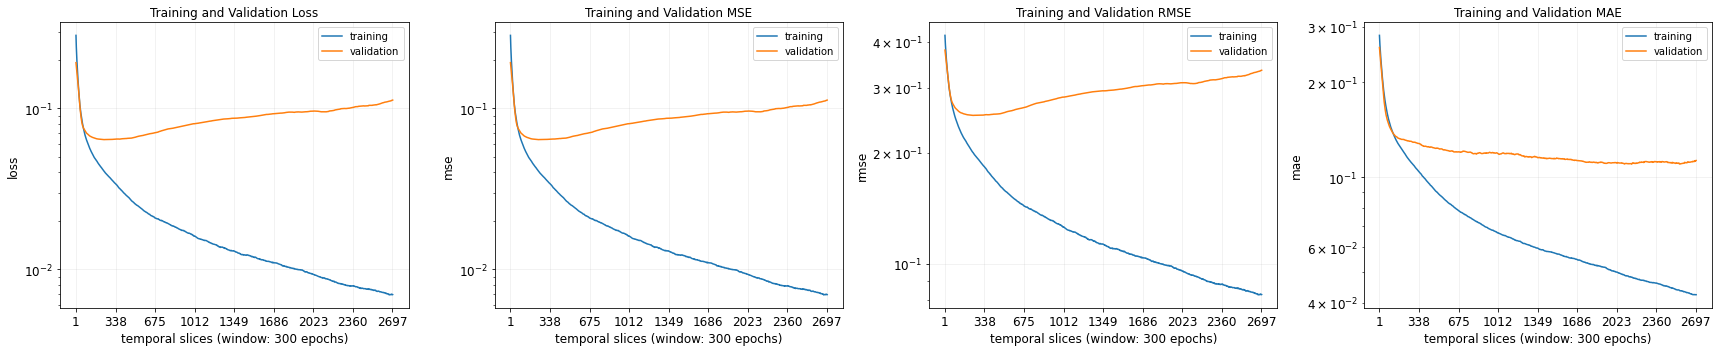

In [88]:
def running_average(values, window):
    '''
    Compute the (simple) running average of a series of data.
    
    Required arguments:
        values: list of values,
        window: temporal window for the computation.
    '''
    values  = np.reshape(values, (-1,1)) #------------------------ reshape the list to a n x 1 column vector
    run_avg = np.zeros((np.shape(values)[0] - window + 1, 1)) #--- the no. of valid averages is n - window + 1
    
    for i in range(run_avg.shape[0]):
        run_avg[i,:] = np.sum(values[i:i + window,:]) / window #-- take 'window' values and compute their average
    
    return run_avg #---------------------------------------------- return the running averages

# use a temporal slice
win  = int(np.shape(ann_fc_history['loss'])[0] / 10)
plot = Plot(rows=1, columns=4)

plot.series2D(data=running_average(ann_fc_history['loss'], win),
              axis=0,
              title='Training and Validation Loss',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='loss',
              legend='training',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['loss'], win))[0] / 8)
             )\
    .series2D(data=running_average(ann_fc_history['val_loss'], win),
              axis=0,
              title='Training and Validation Loss',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='loss',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['loss'], win))[0] / 8)
             )
plot.series2D(data=running_average(ann_fc_history['mean_squared_error'], win),
              axis=1,
              title='Training and Validation MSE',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='mse',
              legend='training',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['mean_squared_error'], win))[0] / 8)
             )\
    .series2D(data=running_average(ann_fc_history['val_mean_squared_error'], win),
              axis=1,
              title='Training and Validation MSE',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='mse',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['mean_squared_error'], win))[0] / 8)
             )
plot.series2D(data=running_average(ann_fc_history['root_mean_squared_error'], win),
              axis=2,
              title='Training and Validation RMSE',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='rmse',
              legend='training',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['root_mean_squared_error'], win))[0] / 8)
             )\
    .series2D(data=running_average(ann_fc_history['val_root_mean_squared_error'], win),
              axis=2,
              title='Training and Validation RMSE',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='rmse',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['root_mean_squared_error'], win))[0] / 8)
             )
plot.series2D(data=running_average(ann_fc_history['mean_absolute_error'], win),
              axis=3,
              title='Training and Validation MAE',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='mae',
              legend='training',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['mean_absolute_error'], win))[0] / 8)
             )\
    .series2D(data=running_average(ann_fc_history['val_mean_absolute_error'], win),
              axis=3,
              title='Training and Validation MAE',
              xlabel='temporal slices (window: {:d} epochs)'.format(win),
              ylabel='mae',
              legend='validation',
              ylog=True,
              binstep=int(np.shape(running_average(ann_fc_history['mean_absolute_error'], win))[0] / 8)
             )

plot.save_and_close(path.join(IMG_PATH, 'ann_fc_metrics_run_avg_plot'))

It clearly shows that starting from a certain value of the training epochs the loss starts to increase again: we kept only the best result using the callback `ModelCheckpoint` in `Keras`.

We then save the results of the training to file:

In [89]:
import joblib
import json

from tensorflow.keras.utils import model_to_dot

# write history file
joblib.dump(ann_fc_history, path.join(OUT_PATH, 'ann_fc_history.pkl.xz'), compress=('xz',9))

# write summary
with open(path.join(OUT_PATH, 'ann_fc_config.json'), 'w') as f:
    json.dump(ann_fc.get_config(), f)
    
# print summary
ann_fc.summary()
    
# print model image
ann_fc_dot = model_to_dot(model=ann_fc,
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=False,
                          dpi=96,
                          subgraph=False)
ann_fc_dot.write_pdf(path.join(IMG_PATH, 'ann_fc_architecture.pdf'))

Model: "sft_trunc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              (None, 15)                300       
_________________________________________________________________
activation_0 (LeakyReLU)     (None, 15)                0         
_________________________________________________________________
batch_norm_0 (BatchNormaliza (None, 15)                60        
_________________________________________________________________
dropout_0 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
activation_1 (LeakyReLU)     (None, 15)                0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 15)                60

Finally we visualise the distribution of the variance of the errors in plots:

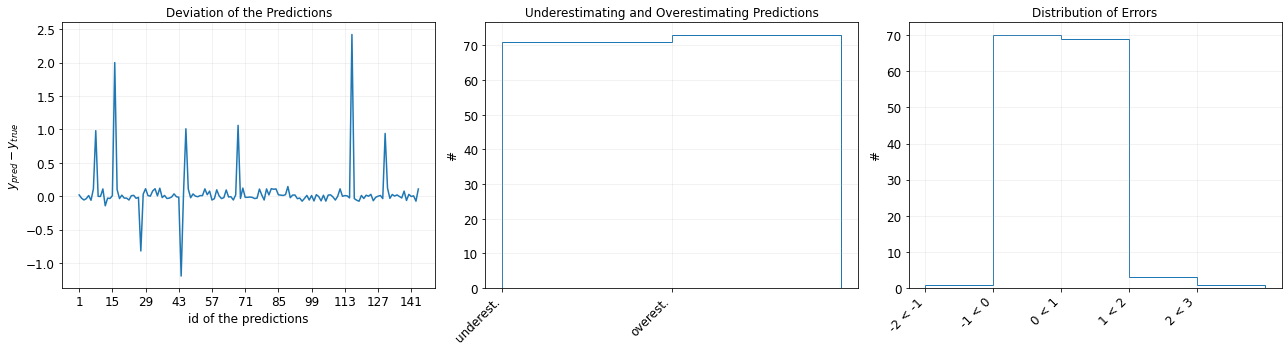

In [90]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'ann_fc_errors'))

The ANN does not look to improve the results of the trees even though results are comparable. However we can see that:

- MSE is worse than BDTs but other metrics are comparable with them,
- the confidence interval is smaller than linear regression models,
- errors seem to be mainly underestimating the true values but the number of large errors is reduced.

## Test Set Performance Evaluation

We then show the predictions on the test set of the considered algorithms:

We start from linear regression:

Results for LR:

  MSE:  0.234
  R2:   0.542
  EVAR: 0.553


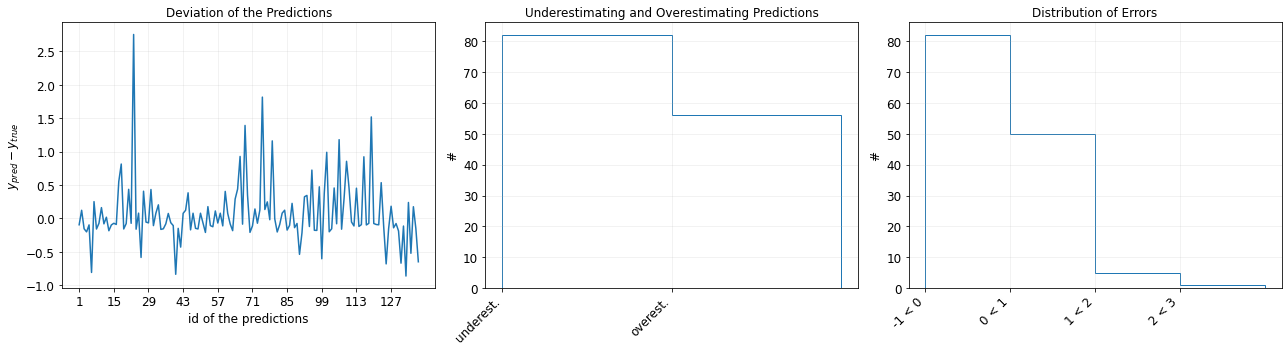

In [91]:
import joblib

# compute the predictions
y_test_pred = lin_reg.predict(X_test).reshape(-1,1)

# print the metrics
print('Results for LR:')
print_metrics(y_test, y_test_pred)

# save the predictions
def save_res_test(short_name):
    '''
    Save results of the test predictions to file.
    
    Required arguments:
        short_name: a short identifier of the estimator considered.
    '''
    # save predictions to file
    test_predictions = {'y_dev_true': y_test.squeeze().tolist(),
                        'y_dev_pred': y_test_pred.squeeze().tolist(),
                        'y_dev_err':  (y_test_pred - y_test).squeeze().tolist()
                       }
    joblib.dump(test_predictions, path.join(OUT_PATH, short_name + '_test_preds.pkl.xz'), compress=('xz',9))

save_res_test('lin_reg')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'lin_reg_test_errors'))

We then show the same results for the elastic net:

Results for EN:

  MSE:  0.251
  R2:   0.508
  EVAR: 0.521


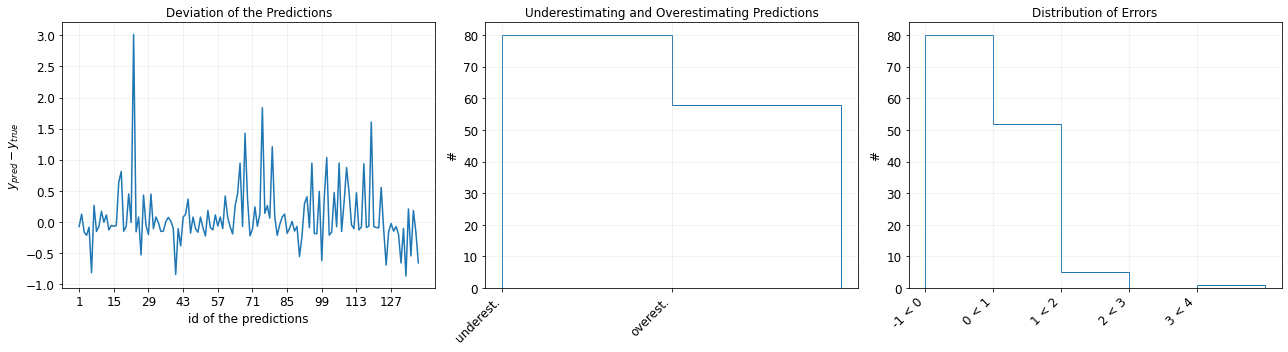

In [92]:
# compute the predictions
y_test_pred = el_net.predict(X_test).reshape(-1,1)

# print the metrics
print('Results for EN:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('el_net')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'el_net_test_errors'))

We show the results in the presence of regularisation with the lasso regression:

Results for LASSO:

  MSE:  0.252
  R2:   0.506
  EVAR: 0.518


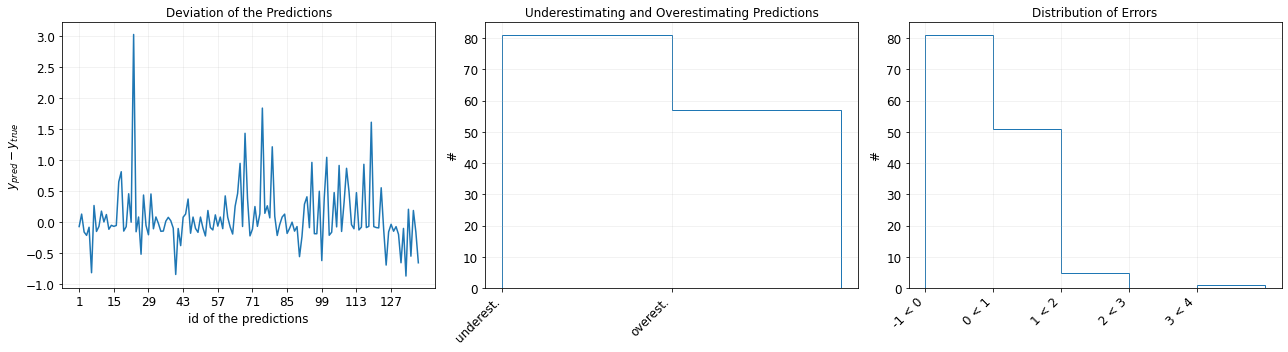

In [93]:
# compute the predictions
y_test_pred = lasso.predict(X_test).reshape(-1,1)

# print the metrics
print('Results for LASSO:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('lasso')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'lasso_test_errors'))

We the move to the linear SVR (i.e. no kernel trick):

Results for l-SVR:

  MSE:  0.312
  R2:   0.388
  EVAR: 0.392


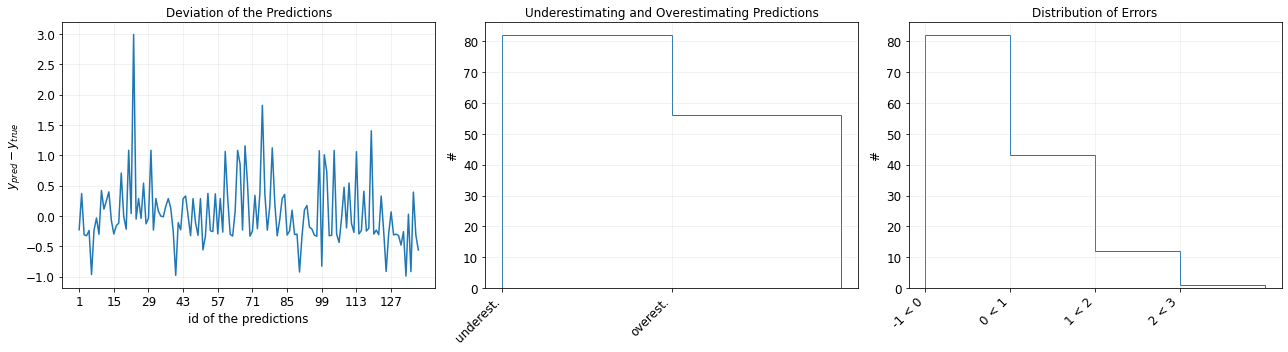

In [94]:
# compute the predictions
y_test_pred = lin_svr.predict(X_test).reshape(-1,1)

# print the metrics
print('Results for l-SVR:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('lin_svr')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'lin_svr_test_errors'))

We show the improvements brought by the kernel trick in the SVR:

Results for SVR:

  MSE:  0.258
  R2:   0.495
  EVAR: 0.500


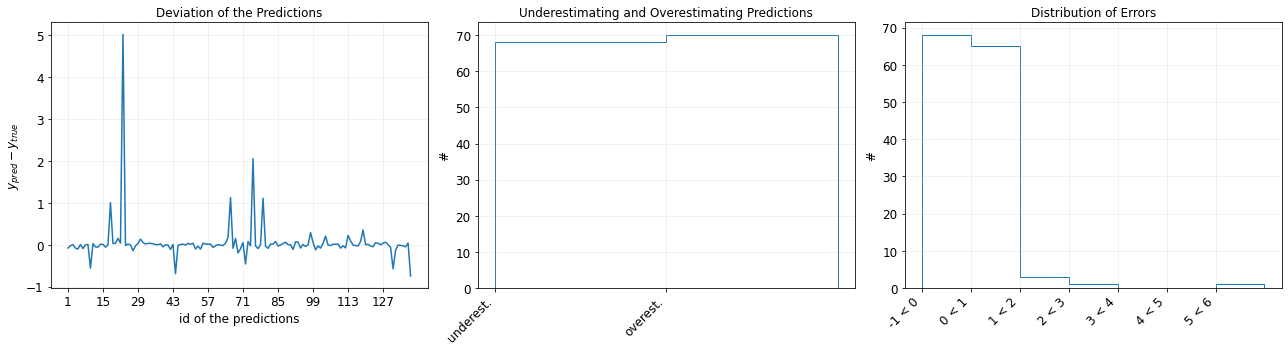

In [95]:
# compute the predictions
y_test_pred = svr_rbf.predict(X_test).reshape(-1,1)

# print the metrics
print('Results for SVR:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('svr_rbf')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'svr_rbf_test_errors'))

We then move to the implementation of the random forests:

Results for RF:

  MSE:  0.289
  R2:   0.433
  EVAR: 0.433


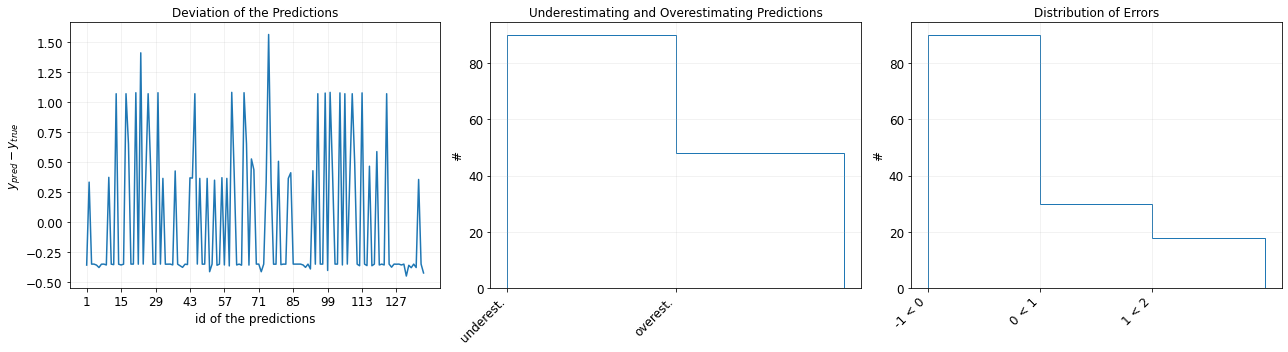

In [96]:
# compute the predictions
y_test_pred = rnd_for.predict(dtest).reshape(-1,1)

# print the metrics
print('Results for RF:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('rnd_for')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'rnd_for_test_errors'))

The we show the boosted trees:

Results for BDT:

  MSE:  0.044
  R2:   0.914
  EVAR: 0.915


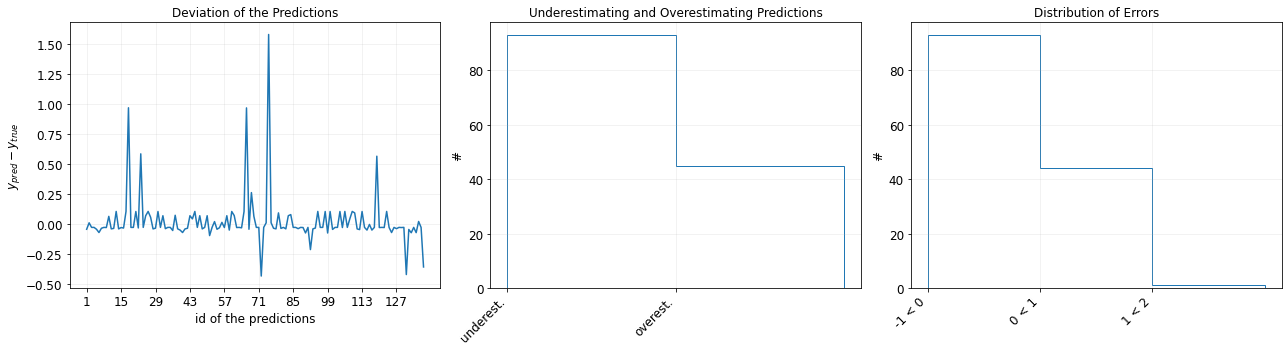

In [97]:
# compute the predictions
y_test_pred = bst_tree.predict(dtest).reshape(-1,1)

# print the metrics
print('Results for BDT:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('bst_tree')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'bst_tree_test_errors'))

We show the predictions of the boosted forests:

Results for BRF:

  MSE:  0.040
  R2:   0.922
  EVAR: 0.924


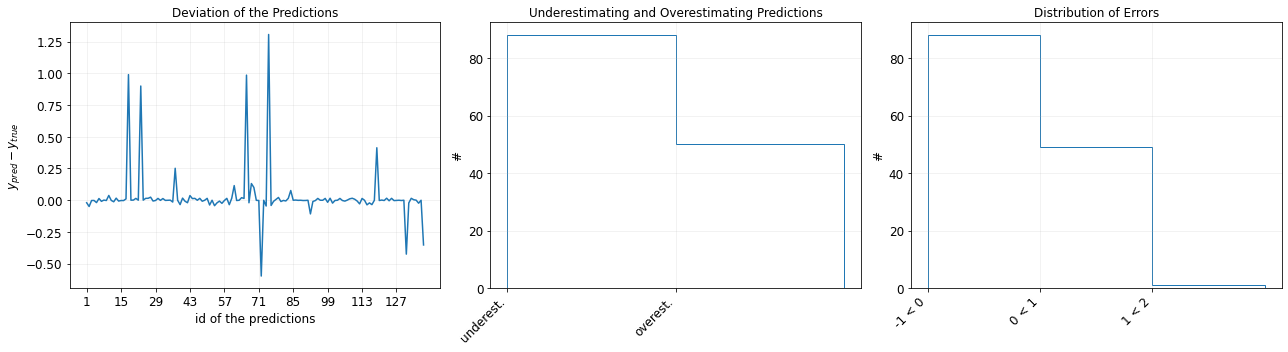

In [98]:
# compute the predictions
y_test_pred = bst_for.predict(dtest).reshape(-1,1)

# print the metrics
print('Results for BRF:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('bst_for')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'bst_for_test_errors'))

We finally show the predictions of the neural netowrk:

Results for the ANN:

  MSE:  0.097
  R2:   0.809
  EVAR: 0.814


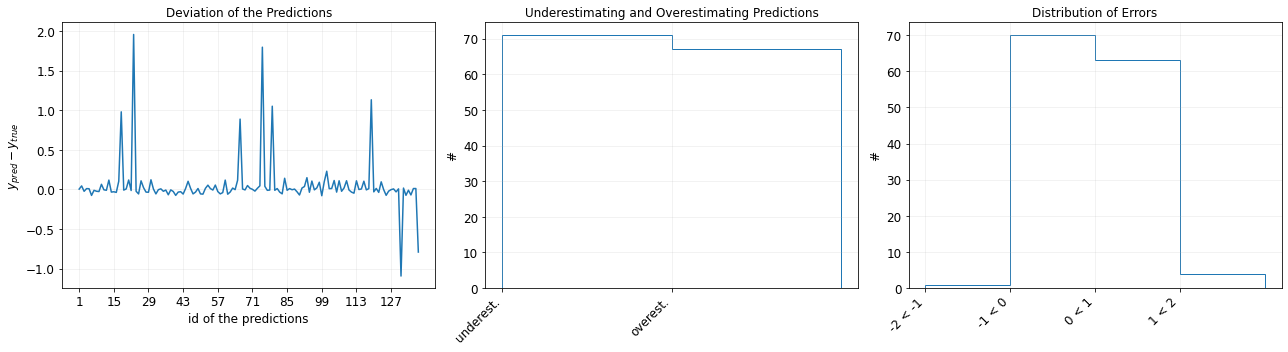

In [99]:
# compute the predictions
y_test_pred = ann_fc.predict(X_test).reshape(-1,1)

# print the metrics
print('Results for the ANN:')
print_metrics(y_test, y_test_pred)

# save the predictions
save_res_test('ann_fc')

# visualise the errors
plot = error_visualisation(y_test, y_test_pred)
plot.save_and_close(path.join(IMG_PATH, 'ann_fc_test_errors'))